The Project

The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images 
2. Train a classifier Linear SVM classifier
3. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
4. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
5. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) 
6. Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
7. Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

  
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
#                     xy_window=(64, 64), xy_overlap=(0.5, 0.5), window_list=[]):
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5), window_list=[]):
    print("window_list: ", len(window_list))
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
#     window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    print(nx_pix_per_step)
    print(ny_pix_per_step)
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [2]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
            
    #1) Define an empty list to receive features
    img_features = []
    
#     print("hog_feat in single img features: ", hog_feat)
#     print("hist in single img features: ", hist_feat)
#     print("spatial in single img features: ", spatial_feat)
#     print("colorspace:", color_space)


    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    

    
    #3) Compute spatial features if flag is set
    
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
   
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features_one_channel, hog_image = get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
                hog_features.extend(hog_features_one_channel)

        else:
            hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)

        #8) Append features to list
        img_features.append(hog_features)


    #9) Return concatenated array of features
    
    # Create an array stack, NOTE: StandardScaler() expects np.float64
#     print("vstack: ", np.vstack(img_features).astype(np.float64 ).shape)
#     print("concatenate: ", np.concatenate(img_features).shape)
    
    return np.concatenate(img_features)

# Define a function you will pass an image 
# # and the list of windows to be searched (output of slide_windows())
# def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                     spatial_size=(32, 32), hist_bins=32, 
#                     hist_range=(0, 256), orient=9, 
#                     pix_per_cell=8, cell_per_block=2, 
#                     hog_channel=0, spatial_feat=True, 
#                     hist_feat=True, hog_feat=True):
    
    

def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size, hist_bins, 
                    hist_range, orient, 
                    pix_per_cell, cell_per_block, 
                    hog_channel, spatial_feat, 
                    hist_feat, hog_feat):


    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), hog_channel = ('ALL'), spatial_feat = False, hist_feat = False):
    
    print('Spatial_feat: ', spatial_feat)
    print('hist_feat: ', hist_feat)
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
#         print("file ", file)
        image = mpimg.imread(file)
    

        # Read in each one by one
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)    
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
    #         print("spatial feature: ", len(spatial_features))
            # Apply color_hist() also with a color space option now
       
        if hist_feat: 
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
#         print("hist feature: ", len(hist_features))

        #7) Compute HOG features if flag is set

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#
#         print("hog feature: ", len(hog_features))

        # Append the new feature vector to the features list
        if hist_feat and spatial_feat:
#             print("spatial, hist and hog features extracted")
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        elif hist_feat:
#             print("hist and hog features extracted")
            features.append(np.concatenate((hist_features, hog_features)))
        elif spatial_feat:
#             print("spatial and hog features extracted")

            features.append(np.concatenate((spatial_features, hog_features)))
        else:
#             print("ony hog features extracted")
            features.append(hog_features)

                
        
        
        


            
#         print(" feature: ", len(features))

    # Return list of feature vectors

    return features
    

not_cars length:  8968
car length:  8792
./training_test_data/vehicles/GTI_Far/image0000.png
not_cars length:  8968
car length:  8792
Spatial_feat:  False
hist_feat:  False


/Users/tvdo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:167: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Spatial_feat:  False
hist_feat:  False
notcar_features length:  7000
car_features length:  700


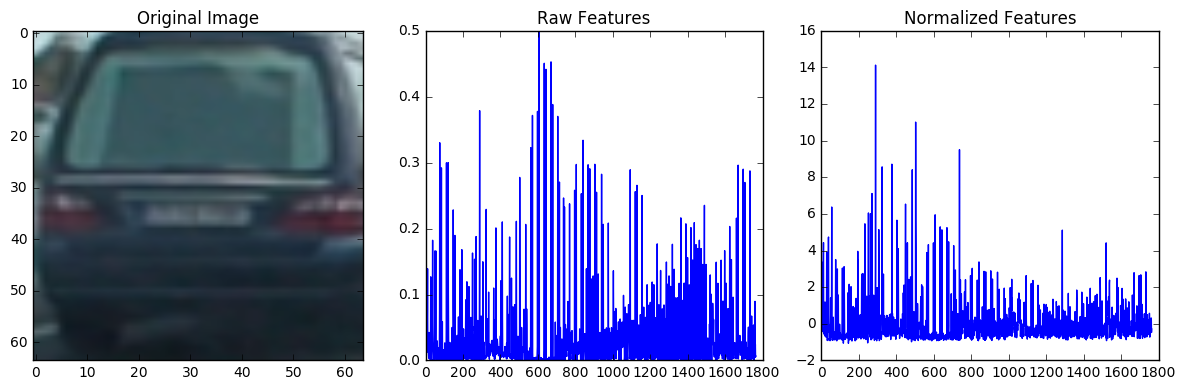

y shape:  (7700,)
X_train size:  5390
y_train size:  5390
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
4.95 Seconds to train SVC...
Test Accuracy of SVC =  0.9775


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from skimage.feature import hog
from sklearn import svm

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle


# MAIN 1

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb'
# color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = '0' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hist_range=(0,256)
hog_feat = True # HOG features on or off

image = mpimg.imread('./test_images/test1.jpg')
y_start_stop=[int(image.shape[0]/2), int(image.shape[0])]# Min and max in y to search in slide_window()



not_cars=[]
not_cars.extend(glob.glob('./training_test_data/non-vehicles/Extras/*.png'))
not_cars.extend(glob.glob('./training_test_data/non-vehicles/GTI/*.png'))
# print(not_cars)

cars=[]


cars.extend(glob.glob('./training_test_data/vehicles/GTI_Far/*.png'))
cars.extend(glob.glob('./training_test_data/vehicles/GTI_Left/*.png'))
cars.extend(glob.glob('./training_test_data/vehicles/GTI_MiddleClose/*.png'))
cars.extend(glob.glob('./training_test_data/vehicles/GTI_Right/*.png'))
cars.extend(glob.glob('./training_test_data/vehicles/KITTI_extracted/*.png'))

print("not_cars length: ", len(not_cars))
print("car length: ", len(cars))
print(cars[0])
cars = shuffle(cars)
not_cars = shuffle(not_cars)



# #generate more not_car data than car data to reduce false positives
# for i in range(0,3):
#     not_cars_copy = np.copy(not_cars)
#     not_cars.extend(not_cars_copy)
#     print(len(not_cars))
# #     print(not_cars.shape)

print("not_cars length: ", len(not_cars))
print("car length: ", len(cars))

# mergedlist.extend(listone)


cars=cars[0:700]
not_cars=not_cars[0:7000]


car_features = extract_features(cars, color_space, spatial_size, hist_bins, hist_range, hog_channel, spatial_feat = spatial_feat, hist_feat=hist_feat)
notcar_features = extract_features(not_cars, color_space, spatial_size, hist_bins, hist_range, hog_channel, spatial_feat = spatial_feat, hist_feat=hist_feat)


print("notcar_features length: ", len(notcar_features))
print("car_features length: ", len(car_features))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

plt.show()

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("y shape: ", y.shape)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.3, random_state=rand_state)

print("X_train size: ", len(X_train))
print("y_train size: ", len(y_train))

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC label
# svc = LinearSVC()
# svc = svm.SVC(kernel='linear', class_weight={0:.01, 1:.99})
svc = svm.SVC(kernel='linear')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))
#https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/de41bff0-ad52-493f-8ef4-5506a279b812


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


720
window_list:  0
19
19


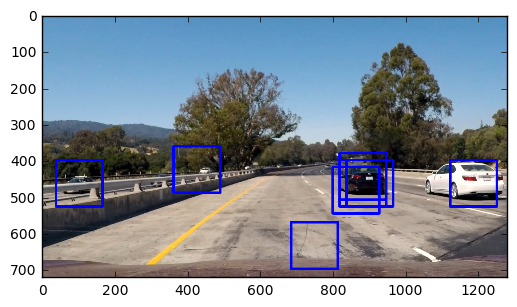

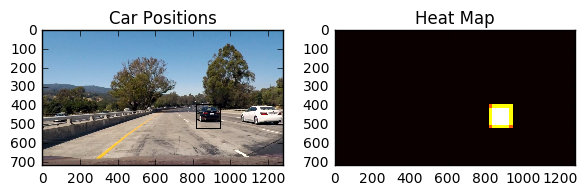

window_list:  0
19
19


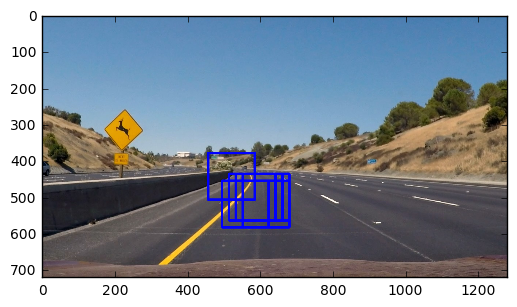

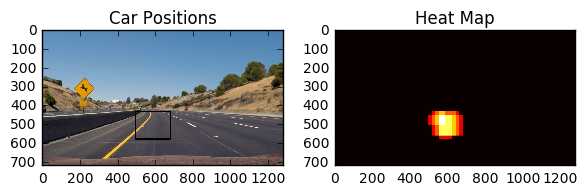

window_list:  0
19
19


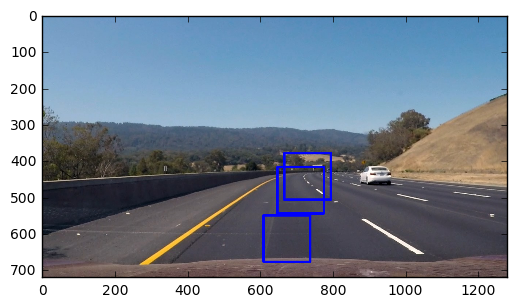

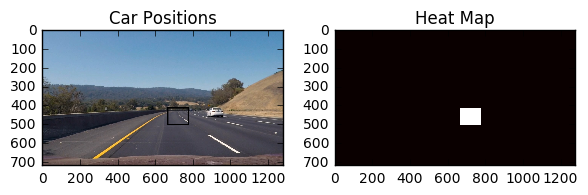

window_list:  0
19
19


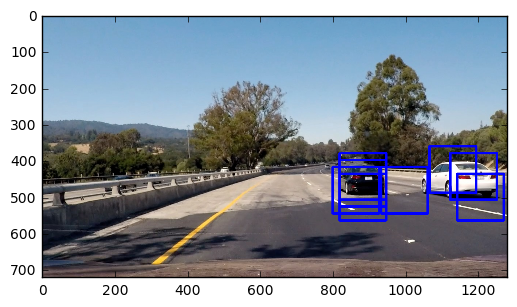

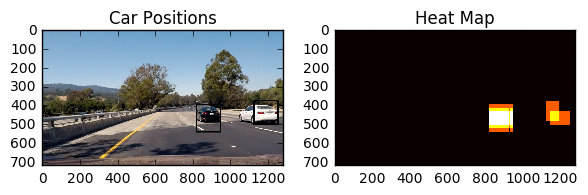

window_list:  0
19
19


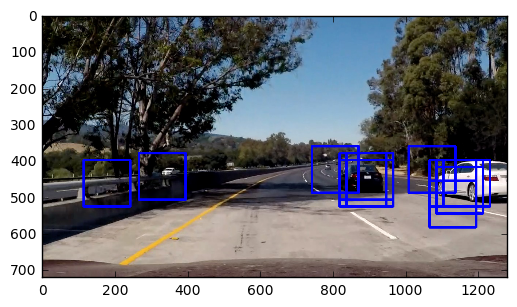

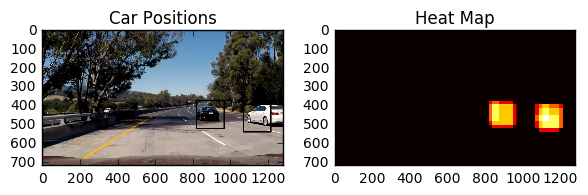

window_list:  0
19
19


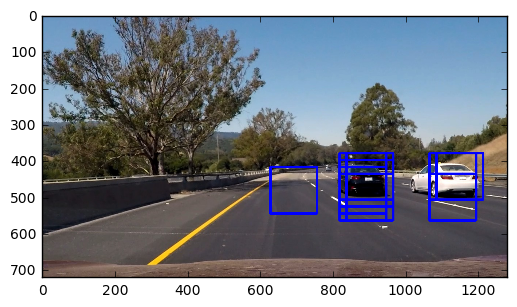

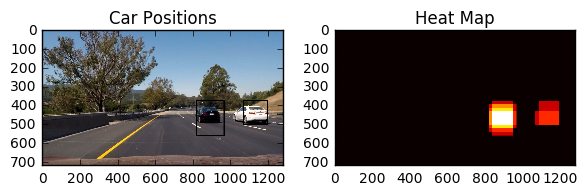

In [6]:
import time
img = [] 
image = mpimg.imread('./test_images/test1.jpg')
img.append(image)
image = mpimg.imread('./test_images/test2.jpg')
img.append(image)
image = mpimg.imread('./test_images/test3.jpg')
img.append(image)
image = mpimg.imread('./test_images/test4.jpg')
img.append(image)
image = mpimg.imread('./test_images/test5.jpg')
img.append(image)
image = mpimg.imread('./test_images/test6.jpg')
img.append(image)

print(image.shape[0])
xy_overlap = (0.85, 0.85)

for image in img:
    
    draw_image = np.copy(image)

    windows=[]

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    
    #small_windows
#     windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(64, 64), xy_overlap=xy_overlap,window_list=windows)

    # print("Length after small_windows:" , len(windows))

    # ##mid_windows
    # windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #                     xy_window=(96*2, 96*2), xy_overlap=xy_overlap, window_list=windows)

    # print("Length after mid_windows:" , len(windows))

    ##L_windows
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=xy_overlap, window_list=windows)

    # print("Length after L_windows:" , len(windows))

    # ##XL_windows
    # windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #                     xy_window=(96*4, 96*4), xy_overlap=xy_overlap, window_list=windows)

    # print("Length after XL_windows:" , len(windows))


    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, hist_range = hist_range)            
#     len(mid_windows)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    plt.imshow(window_img)

    plt.show()
    # Read in image similar to one shown above 
    # image = mpimg.imread('./test_images/test1.jpg')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

    plt.show()

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from io import StringIO

# white_output = 'test_video_output.mp4'
# clip1 = VideoFileClip("test_video.mp4")
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")

# clip1 = VideoFileClip("test_video.mp4", audio=True).subclip(0.5,0.6)
# clip1 = VideoFileClip("project_video.mp4", audio=True).subclip(2,3)

global counter, draw_img
counter = 0
every_x_frames = 1


##needed for lane detection
global src_upper_right, src_lower_right, src_lower_left, src_upper_left
global offset_leftx, offset_rightx

src_upper_right = (703, 461)
src_lower_right = (1093, 715)
src_lower_left= (220, 715)
src_upper_left= (580,461)
# offset for dst points
offset_leftx = 200 
offset_rightx = 300 


def process_image(image):
    global draw_img, counter

    counter = counter + 1 
    if (counter % every_x_frames) == 0:
        draw_image = np.copy(image)

        ##################### DETECT LANES
        ##########FOR LANE FINDING
        # Define a function that takes an undistorted, color thresholded and gradient thresholded image, and transform it.


        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here

     

        global transform_offset_rightx, transform_offset_leftx 
        transform_offset_rightx = src_lower_right[0]-(image.shape[1]-offset_rightx)
        #Example 1093 - (1280-300) = 113 --> so example x coordinate in transform of 800 represents x coordinate in original image of 913 
        transform_offset_leftx = src_lower_left[0]-(offset_leftx)


        global initial_polynomials_found, left_fit, left_fitx, leftx, right_fit, right_fitx, rightx, ploty
        img = np.copy(image)
        undistorted = img
    #     undistorted = cal_undistort(img, objpoints, imgpoints) Skipping calibration. See: https://github.com/Thomas0176/Advanced-Lane-Lines/blob/master/main.ipynb
        combined_binary = color_and_gradient_threshold(undistorted)
        #perspective transform
        binary_warped, M, Minv = unwarp(combined_binary)

        initial_polynomials_found = False

        if not initial_polynomials_found:
            #for first image define left and right polynomials of lanes (left_fit, right_fit). We will use those polynomials in the subsequent images
            out_img, out_img_red, left_fit, left_fitx, leftx, lefty, right_fit, right_fitx, rightx, righty, ploty  = generate_polynomial(binary_warped)
            initial_polynomials_found = True

        else:
            out_img, out_img_red, left_fit, left_fitx, leftx, lefty, right_fit, right_fitx, rightx, righty, ploty = update_polynomial(binary_warped, left_fit, right_fit)


        left_curverad, right_curverad, offset_from_lane_center = left_right_curverad(left_fit, leftx, lefty, right_fit, rightx, righty, ploty, undistorted)

        lanes_on_original = draw_lanes_on_original_img(undistorted,out_img_red,Minv,left_fitx, right_fitx, ploty)



        ########################### ADD DETECTIONS

        image = image.astype(np.float32)/255

        # print("NEW DATA: ", np.hstack((small_windows,mid_windows)))
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat, hist_range = hist_range)            

        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

         # Read in image similar to one shown above 
        # image = mpimg.imread('./test_images/test1.jpg')
        heat = np.zeros_like(image[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat,hot_windows)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat,2)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)

    #     draw_img = draw_labeled_bboxes(np.copy(draw_image), labels)
        draw_img = draw_labeled_bboxes(np.copy(lanes_on_original), labels)

    #     plt.imshow(window_img)

    #     plt.show()
    return draw_img

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)


# # Overlay the text clip on the first video clip
# video = CompositeVideoClip([clip, txt_clip])

# # Write the result to a file
# video.write_videofile("myHolidays_edited.avi",fps=24, codec='mpeg4')

113
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

113


  0%|          | 1/1261 [00:10<3:40:34, 10.50s/it]

113


  0%|          | 2/1261 [00:21<3:43:00, 10.63s/it]

113


  0%|          | 3/1261 [00:31<3:42:07, 10.59s/it]

113


  0%|          | 4/1261 [00:42<3:39:56, 10.50s/it]

113


  0%|          | 5/1261 [00:53<3:42:07, 10.61s/it]

113


  0%|          | 6/1261 [01:04<3:48:21, 10.92s/it]

113


  1%|          | 7/1261 [01:15<3:49:26, 10.98s/it]

113


  1%|          | 8/1261 [01:26<3:50:11, 11.02s/it]

113


  1%|          | 9/1261 [01:37<3:49:16, 10.99s/it]

113


  1%|          | 10/1261 [01:48<3:48:31, 10.96s/it]

113


  1%|          | 11/1261 [01:58<3:42:29, 10.68s/it]

113


  1%|          | 12/1261 [02:09<3:40:00, 10.57s/it]

113


  1%|          | 13/1261 [02:19<3:40:43, 10.61s/it]

113


  1%|          | 14/1261 [02:31<3:44:55, 10.82s/it]

113


  1%|          | 15/1261 [02:42<3:48:04, 10.98s/it]

113


  1%|▏         | 16/1261 [02:53<3:50:01, 11.09s/it]

113


  1%|▏         | 17/1261 [03:04<3:49:34, 11.07s/it]

113


  1%|▏         | 18/1261 [03:15<3:49:17, 11.07s/it]

113


  2%|▏         | 19/1261 [03:26<3:45:52, 10.91s/it]

113


  2%|▏         | 20/1261 [03:37<3:44:51, 10.87s/it]

113


  2%|▏         | 21/1261 [03:47<3:38:48, 10.59s/it]

113


  2%|▏         | 22/1261 [03:57<3:35:49, 10.45s/it]

113


  2%|▏         | 23/1261 [04:07<3:35:18, 10.44s/it]

113


  2%|▏         | 24/1261 [04:18<3:34:30, 10.40s/it]

113


  2%|▏         | 25/1261 [04:28<3:33:59, 10.39s/it]

113


  2%|▏         | 26/1261 [04:39<3:35:45, 10.48s/it]

113


  2%|▏         | 27/1261 [04:49<3:36:17, 10.52s/it]

113


  2%|▏         | 28/1261 [05:00<3:37:57, 10.61s/it]

113


  2%|▏         | 29/1261 [05:11<3:38:34, 10.64s/it]

113


  2%|▏         | 30/1261 [05:22<3:41:42, 10.81s/it]

113


  2%|▏         | 31/1261 [05:32<3:36:28, 10.56s/it]

113


  3%|▎         | 32/1261 [05:42<3:32:45, 10.39s/it]

113


  3%|▎         | 33/1261 [05:52<3:32:44, 10.39s/it]

113


  3%|▎         | 34/1261 [06:03<3:36:24, 10.58s/it]

113


  3%|▎         | 35/1261 [06:14<3:38:08, 10.68s/it]

113


  3%|▎         | 36/1261 [06:25<3:37:56, 10.68s/it]

113


  3%|▎         | 37/1261 [06:35<3:34:44, 10.53s/it]

113


  3%|▎         | 38/1261 [06:46<3:34:09, 10.51s/it]

113


  3%|▎         | 39/1261 [06:56<3:36:03, 10.61s/it]

113


  3%|▎         | 40/1261 [07:07<3:34:07, 10.52s/it]

113


  3%|▎         | 41/1261 [07:19<3:42:07, 10.92s/it]

113


  3%|▎         | 42/1261 [07:30<3:47:26, 11.19s/it]

113


  3%|▎         | 43/1261 [07:42<3:52:02, 11.43s/it]

113


  3%|▎         | 44/1261 [07:53<3:46:57, 11.19s/it]

113


  4%|▎         | 45/1261 [08:04<3:45:20, 11.12s/it]

113


  4%|▎         | 46/1261 [08:15<3:44:30, 11.09s/it]

113


  4%|▎         | 47/1261 [08:26<3:42:16, 10.99s/it]

113


  4%|▍         | 48/1261 [08:36<3:38:59, 10.83s/it]

113


  4%|▍         | 49/1261 [08:46<3:33:43, 10.58s/it]

113


  4%|▍         | 50/1261 [08:57<3:35:26, 10.67s/it]

113


  4%|▍         | 51/1261 [09:08<3:38:21, 10.83s/it]

113


  4%|▍         | 52/1261 [09:19<3:35:50, 10.71s/it]

113


  4%|▍         | 53/1261 [09:29<3:34:55, 10.68s/it]

113


  4%|▍         | 54/1261 [09:39<3:31:43, 10.52s/it]

113


  4%|▍         | 55/1261 [09:50<3:29:02, 10.40s/it]

113


  4%|▍         | 56/1261 [10:00<3:26:42, 10.29s/it]

113


  5%|▍         | 57/1261 [10:10<3:25:18, 10.23s/it]

113


  5%|▍         | 58/1261 [10:20<3:25:29, 10.25s/it]

113


  5%|▍         | 59/1261 [10:31<3:31:32, 10.56s/it]

113


  5%|▍         | 60/1261 [10:43<3:38:50, 10.93s/it]

113


  5%|▍         | 61/1261 [10:54<3:40:17, 11.01s/it]

113


  5%|▍         | 62/1261 [11:05<3:40:04, 11.01s/it]

113


  5%|▍         | 63/1261 [11:16<3:37:37, 10.90s/it]

113


  5%|▌         | 64/1261 [11:26<3:33:38, 10.71s/it]

113


  5%|▌         | 65/1261 [11:37<3:35:26, 10.81s/it]

113


  5%|▌         | 66/1261 [11:48<3:36:30, 10.87s/it]

113


  5%|▌         | 67/1261 [11:58<3:31:38, 10.64s/it]

113


  5%|▌         | 68/1261 [12:08<3:28:13, 10.47s/it]

113


  5%|▌         | 69/1261 [12:18<3:25:26, 10.34s/it]

113


  6%|▌         | 70/1261 [12:29<3:24:09, 10.28s/it]

113


  6%|▌         | 71/1261 [12:39<3:24:01, 10.29s/it]

113


  6%|▌         | 72/1261 [12:50<3:26:39, 10.43s/it]

113


  6%|▌         | 73/1261 [13:00<3:28:12, 10.52s/it]

113


  6%|▌         | 74/1261 [13:11<3:29:12, 10.57s/it]

113


  6%|▌         | 75/1261 [13:21<3:27:29, 10.50s/it]

113


  6%|▌         | 76/1261 [13:31<3:24:42, 10.36s/it]

113


  6%|▌         | 77/1261 [13:42<3:25:31, 10.42s/it]

113


  6%|▌         | 78/1261 [13:52<3:24:24, 10.37s/it]

113


  6%|▋         | 79/1261 [14:02<3:22:36, 10.28s/it]

113


  6%|▋         | 80/1261 [14:12<3:21:03, 10.21s/it]

113


  6%|▋         | 81/1261 [14:23<3:22:02, 10.27s/it]

113


  7%|▋         | 82/1261 [14:33<3:21:27, 10.25s/it]

113


  7%|▋         | 83/1261 [14:43<3:19:25, 10.16s/it]

113


  7%|▋         | 84/1261 [14:53<3:19:37, 10.18s/it]

113


  7%|▋         | 85/1261 [15:04<3:23:20, 10.37s/it]

113


  7%|▋         | 86/1261 [15:15<3:28:22, 10.64s/it]

113


  7%|▋         | 87/1261 [15:27<3:31:51, 10.83s/it]

113


  7%|▋         | 88/1261 [15:38<3:34:18, 10.96s/it]

113


  7%|▋         | 89/1261 [15:49<3:34:37, 10.99s/it]

113


  7%|▋         | 90/1261 [16:00<3:35:08, 11.02s/it]

113


  7%|▋         | 91/1261 [16:11<3:32:49, 10.91s/it]

113


  7%|▋         | 92/1261 [16:21<3:30:46, 10.82s/it]

113


  7%|▋         | 93/1261 [16:32<3:32:57, 10.94s/it]

113


  7%|▋         | 94/1261 [16:44<3:33:40, 10.99s/it]

113


  8%|▊         | 95/1261 [16:55<3:34:56, 11.06s/it]

113


  8%|▊         | 96/1261 [17:06<3:35:56, 11.12s/it]

113


  8%|▊         | 97/1261 [17:17<3:36:26, 11.16s/it]

113


  8%|▊         | 98/1261 [17:28<3:31:42, 10.92s/it]

113


  8%|▊         | 99/1261 [17:39<3:33:36, 11.03s/it]

113


  8%|▊         | 100/1261 [17:49<3:29:30, 10.83s/it]

113


  8%|▊         | 101/1261 [18:00<3:30:24, 10.88s/it]

113


  8%|▊         | 102/1261 [18:10<3:25:05, 10.62s/it]

113


  8%|▊         | 103/1261 [18:20<3:20:32, 10.39s/it]

113


  8%|▊         | 104/1261 [18:30<3:17:17, 10.23s/it]

113


  8%|▊         | 105/1261 [18:40<3:18:06, 10.28s/it]

113


  8%|▊         | 106/1261 [18:51<3:22:34, 10.52s/it]

113


  8%|▊         | 107/1261 [19:02<3:23:22, 10.57s/it]

113


  9%|▊         | 108/1261 [19:12<3:20:23, 10.43s/it]

113


  9%|▊         | 109/1261 [19:23<3:19:50, 10.41s/it]

113


  9%|▊         | 110/1261 [19:33<3:16:37, 10.25s/it]

113


  9%|▉         | 111/1261 [19:42<3:13:57, 10.12s/it]

113


  9%|▉         | 112/1261 [19:52<3:12:38, 10.06s/it]

113


  9%|▉         | 113/1261 [20:04<3:20:57, 10.50s/it]

113


  9%|▉         | 114/1261 [20:15<3:27:17, 10.84s/it]

113


  9%|▉         | 115/1261 [20:26<3:27:37, 10.87s/it]

113


  9%|▉         | 116/1261 [20:37<3:25:45, 10.78s/it]

113


  9%|▉         | 117/1261 [20:47<3:22:28, 10.62s/it]

113


  9%|▉         | 118/1261 [20:57<3:18:46, 10.43s/it]

113


  9%|▉         | 119/1261 [21:08<3:22:20, 10.63s/it]

113


 10%|▉         | 120/1261 [21:19<3:24:18, 10.74s/it]

113


 10%|▉         | 121/1261 [21:30<3:24:17, 10.75s/it]

113


 10%|▉         | 122/1261 [21:40<3:21:52, 10.63s/it]

113


 10%|▉         | 123/1261 [21:51<3:23:09, 10.71s/it]

113


 10%|▉         | 124/1261 [22:02<3:23:17, 10.73s/it]

113


 10%|▉         | 125/1261 [22:13<3:24:12, 10.79s/it]

113


 10%|▉         | 126/1261 [22:24<3:23:18, 10.75s/it]

113


 10%|█         | 127/1261 [22:34<3:23:33, 10.77s/it]

113


 10%|█         | 128/1261 [22:45<3:22:53, 10.74s/it]

113


 10%|█         | 129/1261 [22:56<3:21:24, 10.68s/it]

113


 10%|█         | 130/1261 [23:06<3:19:24, 10.58s/it]

113


 10%|█         | 131/1261 [23:16<3:17:21, 10.48s/it]

113


 10%|█         | 132/1261 [23:27<3:17:10, 10.48s/it]

113


 11%|█         | 133/1261 [23:37<3:14:54, 10.37s/it]

113


 11%|█         | 134/1261 [23:48<3:16:49, 10.48s/it]

113


 11%|█         | 135/1261 [23:58<3:17:44, 10.54s/it]

113


 11%|█         | 136/1261 [24:09<3:19:13, 10.63s/it]

113


 11%|█         | 137/1261 [24:20<3:23:11, 10.85s/it]

113


 11%|█         | 138/1261 [24:32<3:24:43, 10.94s/it]

113


 11%|█         | 139/1261 [24:43<3:25:35, 10.99s/it]

113


 11%|█         | 140/1261 [24:53<3:23:52, 10.91s/it]

113


 11%|█         | 141/1261 [25:04<3:22:53, 10.87s/it]

113


 11%|█▏        | 142/1261 [25:15<3:22:51, 10.88s/it]

113


 11%|█▏        | 143/1261 [25:26<3:23:11, 10.90s/it]

113


 11%|█▏        | 144/1261 [25:37<3:21:27, 10.82s/it]

113


 11%|█▏        | 145/1261 [25:47<3:19:46, 10.74s/it]

113


 12%|█▏        | 146/1261 [25:59<3:22:33, 10.90s/it]

113


 12%|█▏        | 147/1261 [26:10<3:23:56, 10.98s/it]

113


 12%|█▏        | 148/1261 [26:21<3:22:51, 10.94s/it]

113


 12%|█▏        | 149/1261 [26:31<3:22:24, 10.92s/it]

113


 12%|█▏        | 150/1261 [26:42<3:19:44, 10.79s/it]

113


 12%|█▏        | 151/1261 [26:52<3:15:26, 10.56s/it]

113


 12%|█▏        | 152/1261 [27:02<3:12:37, 10.42s/it]

113


 12%|█▏        | 153/1261 [27:12<3:10:36, 10.32s/it]

113


 12%|█▏        | 154/1261 [27:22<3:08:54, 10.24s/it]

113


 12%|█▏        | 155/1261 [27:32<3:07:59, 10.20s/it]

113


 12%|█▏        | 156/1261 [27:42<3:07:13, 10.17s/it]

113


 12%|█▏        | 157/1261 [27:52<3:06:11, 10.12s/it]

113


 13%|█▎        | 158/1261 [28:02<3:06:02, 10.12s/it]

113


 13%|█▎        | 159/1261 [28:13<3:05:46, 10.11s/it]

113


 13%|█▎        | 160/1261 [28:23<3:05:35, 10.11s/it]

113


 13%|█▎        | 161/1261 [28:33<3:05:17, 10.11s/it]

113


 13%|█▎        | 162/1261 [28:43<3:04:49, 10.09s/it]

113


 13%|█▎        | 163/1261 [28:53<3:03:54, 10.05s/it]

113


 13%|█▎        | 164/1261 [29:03<3:03:42, 10.05s/it]

113


 13%|█▎        | 165/1261 [29:13<3:03:37, 10.05s/it]

113


 13%|█▎        | 166/1261 [29:23<3:03:14, 10.04s/it]

113


 13%|█▎        | 167/1261 [29:33<3:03:07, 10.04s/it]

113


 13%|█▎        | 168/1261 [29:43<3:02:59, 10.05s/it]

113


 13%|█▎        | 169/1261 [29:53<3:02:41, 10.04s/it]

113


 13%|█▎        | 170/1261 [30:03<3:02:21, 10.03s/it]

113


 14%|█▎        | 171/1261 [30:13<3:02:17, 10.03s/it]

113


 14%|█▎        | 172/1261 [30:23<3:02:01, 10.03s/it]

113


 14%|█▎        | 173/1261 [30:33<3:01:54, 10.03s/it]

113


 14%|█▍        | 174/1261 [30:43<3:01:52, 10.04s/it]

113


 14%|█▍        | 175/1261 [30:53<3:01:48, 10.04s/it]

113


 14%|█▍        | 176/1261 [31:03<3:01:34, 10.04s/it]

113


 14%|█▍        | 177/1261 [31:13<3:01:41, 10.06s/it]

113


 14%|█▍        | 178/1261 [31:24<3:02:07, 10.09s/it]

113


 14%|█▍        | 179/1261 [31:34<3:01:53, 10.09s/it]

113


 14%|█▍        | 180/1261 [31:44<3:01:39, 10.08s/it]

113


 14%|█▍        | 181/1261 [31:54<3:02:03, 10.11s/it]

113


 14%|█▍        | 182/1261 [32:04<3:01:51, 10.11s/it]

113


 15%|█▍        | 183/1261 [32:14<3:02:00, 10.13s/it]

113


 15%|█▍        | 184/1261 [32:24<3:02:01, 10.14s/it]

113


 15%|█▍        | 185/1261 [32:34<3:01:35, 10.13s/it]

113


 15%|█▍        | 186/1261 [32:45<3:01:39, 10.14s/it]

113


 15%|█▍        | 187/1261 [32:55<3:01:34, 10.14s/it]

113


 15%|█▍        | 188/1261 [33:05<3:01:53, 10.17s/it]

113


 15%|█▍        | 189/1261 [33:15<3:02:07, 10.19s/it]

113


 15%|█▌        | 190/1261 [33:25<3:01:19, 10.16s/it]

113


 15%|█▌        | 191/1261 [33:35<3:01:17, 10.17s/it]

113


 15%|█▌        | 192/1261 [33:46<3:00:57, 10.16s/it]

113


 15%|█▌        | 193/1261 [33:56<3:00:32, 10.14s/it]

113


 15%|█▌        | 194/1261 [34:06<3:00:08, 10.13s/it]

113


 15%|█▌        | 195/1261 [34:16<3:00:51, 10.18s/it]

113


 16%|█▌        | 196/1261 [34:26<3:00:42, 10.18s/it]

113


 16%|█▌        | 197/1261 [34:36<3:00:02, 10.15s/it]

113


 16%|█▌        | 198/1261 [34:47<2:59:44, 10.15s/it]

113


 16%|█▌        | 199/1261 [34:57<2:59:18, 10.13s/it]

113


 16%|█▌        | 200/1261 [35:07<2:59:08, 10.13s/it]

113


 16%|█▌        | 201/1261 [35:17<2:59:22, 10.15s/it]

113


 16%|█▌        | 202/1261 [35:27<2:59:13, 10.15s/it]

113


 16%|█▌        | 203/1261 [35:37<2:58:31, 10.12s/it]

113


 16%|█▌        | 204/1261 [35:47<2:58:20, 10.12s/it]

113


 16%|█▋        | 205/1261 [35:57<2:58:10, 10.12s/it]

113


 16%|█▋        | 206/1261 [36:08<2:58:24, 10.15s/it]

113


 16%|█▋        | 207/1261 [36:18<2:58:20, 10.15s/it]

113


 16%|█▋        | 208/1261 [36:28<2:58:00, 10.14s/it]

113


 17%|█▋        | 209/1261 [36:38<2:57:24, 10.12s/it]

113


 17%|█▋        | 210/1261 [36:48<2:57:52, 10.15s/it]

113


 17%|█▋        | 211/1261 [36:58<2:57:09, 10.12s/it]

113


 17%|█▋        | 212/1261 [37:08<2:55:17, 10.03s/it]

113


 17%|█▋        | 213/1261 [37:18<2:54:57, 10.02s/it]

113


 17%|█▋        | 214/1261 [37:28<2:54:34, 10.00s/it]

113


 17%|█▋        | 215/1261 [37:38<2:53:33,  9.96s/it]

113


 17%|█▋        | 216/1261 [37:48<2:52:47,  9.92s/it]

113


 17%|█▋        | 217/1261 [52:38<79:25:57, 273.91s/it]

113


 17%|█▋        | 218/1261 [52:49<56:35:03, 195.31s/it]

113


 17%|█▋        | 219/1261 [53:00<40:30:59, 139.98s/it]

113


 17%|█▋        | 220/1261 [53:11<29:15:14, 101.17s/it]

113


 18%|█▊        | 221/1261 [53:21<21:21:19, 73.92s/it] 

113


 18%|█▊        | 222/1261 [53:32<15:50:49, 54.91s/it]

113


 18%|█▊        | 223/1261 [53:43<12:02:12, 41.75s/it]

113


 18%|█▊        | 224/1261 [53:53<9:18:34, 32.32s/it] 

113


 18%|█▊        | 225/1261 [54:03<7:23:06, 25.66s/it]

113


 18%|█▊        | 226/1261 [54:13<6:00:58, 20.93s/it]

113


 18%|█▊        | 227/1261 [58:29<26:16:00, 91.45s/it]

113


 18%|█▊        | 228/1261 [59:53<25:32:45, 89.03s/it]

113


 18%|█▊        | 229/1261 [1:00:16<19:53:33, 69.39s/it]

113


 18%|█▊        | 230/1261 [1:01:21<19:29:12, 68.04s/it]

113


 18%|█▊        | 231/1261 [1:03:47<26:06:52, 91.27s/it]

113


 18%|█▊        | 232/1261 [1:04:47<23:28:53, 82.15s/it]

113


 18%|█▊        | 233/1261 [1:05:11<18:24:45, 64.48s/it]

113


 19%|█▊        | 234/1261 [1:24:38<112:46:52, 395.34s/it]

113


 19%|█▊        | 235/1261 [1:24:49<79:49:34, 280.09s/it] 

113


 19%|█▊        | 236/1261 [1:25:00<56:47:15, 199.45s/it]

113


 19%|█▉        | 237/1261 [1:25:12<40:40:40, 143.01s/it]

113


 19%|█▉        | 238/1261 [1:25:23<29:24:50, 103.51s/it]

113


 19%|█▉        | 239/1261 [1:25:34<21:30:16, 75.75s/it] 

113


 19%|█▉        | 240/1261 [1:25:46<16:00:31, 56.45s/it]

113


 19%|█▉        | 241/1261 [1:25:56<12:04:16, 42.60s/it]

113


 19%|█▉        | 242/1261 [1:26:06<9:19:57, 32.97s/it] 

113


 19%|█▉        | 243/1261 [1:26:17<7:27:57, 26.40s/it]

113


 19%|█▉        | 244/1261 [1:26:28<6:09:03, 21.77s/it]

113


 19%|█▉        | 245/1261 [1:26:41<5:20:55, 18.95s/it]

113


 20%|█▉        | 246/1261 [1:26:52<4:43:18, 16.75s/it]

113


 20%|█▉        | 247/1261 [1:27:04<4:15:11, 15.10s/it]

113


 20%|█▉        | 248/1261 [1:27:15<3:53:43, 13.84s/it]

113


 20%|█▉        | 249/1261 [1:27:26<3:40:03, 13.05s/it]

113


 20%|█▉        | 250/1261 [1:27:37<3:29:12, 12.42s/it]

113


 20%|█▉        | 251/1261 [1:27:47<3:20:50, 11.93s/it]

113


 20%|█▉        | 252/1261 [1:27:58<3:15:44, 11.64s/it]

113


 20%|██        | 253/1261 [1:28:09<3:12:25, 11.45s/it]

113


 20%|██        | 254/1261 [1:28:21<3:13:15, 11.51s/it]

113


 20%|██        | 255/1261 [1:28:31<3:07:22, 11.18s/it]

113


 20%|██        | 256/1261 [1:28:43<3:07:21, 11.19s/it]

113


 20%|██        | 257/1261 [1:28:53<3:03:19, 10.96s/it]

113


 20%|██        | 258/1261 [1:29:03<2:59:46, 10.75s/it]

113


 21%|██        | 259/1261 [1:29:14<2:59:12, 10.73s/it]

113


 21%|██        | 260/1261 [1:29:25<3:00:13, 10.80s/it]

113


 21%|██        | 261/1261 [1:29:36<3:00:25, 10.83s/it]

113


 21%|██        | 262/1261 [1:29:47<3:02:03, 10.93s/it]

113


 21%|██        | 263/1261 [1:29:58<3:02:10, 10.95s/it]

113


 21%|██        | 264/1261 [1:30:09<2:59:35, 10.81s/it]

113


 21%|██        | 265/1261 [1:30:19<2:56:37, 10.64s/it]

113


 21%|██        | 266/1261 [1:30:29<2:55:09, 10.56s/it]

113


 21%|██        | 267/1261 [1:30:40<2:54:27, 10.53s/it]

113


 21%|██▏       | 268/1261 [1:30:50<2:53:50, 10.50s/it]

113


 21%|██▏       | 269/1261 [1:31:00<2:52:49, 10.45s/it]

113


 21%|██▏       | 270/1261 [1:31:11<2:51:54, 10.41s/it]

113


 21%|██▏       | 271/1261 [1:31:21<2:50:49, 10.35s/it]

113


 22%|██▏       | 272/1261 [1:31:31<2:49:48, 10.30s/it]

113


 22%|██▏       | 273/1261 [1:31:41<2:48:49, 10.25s/it]

113


 22%|██▏       | 274/1261 [1:31:51<2:48:23, 10.24s/it]

113


 22%|██▏       | 275/1261 [1:32:02<2:48:03, 10.23s/it]

113


 22%|██▏       | 276/1261 [1:32:12<2:47:41, 10.22s/it]

113


 22%|██▏       | 277/1261 [1:32:22<2:47:52, 10.24s/it]

113


 22%|██▏       | 278/1261 [1:32:32<2:47:18, 10.21s/it]

113


 22%|██▏       | 279/1261 [1:32:43<2:47:26, 10.23s/it]

113


 22%|██▏       | 280/1261 [1:32:53<2:47:18, 10.23s/it]

113


 22%|██▏       | 281/1261 [1:33:03<2:46:58, 10.22s/it]

113


 22%|██▏       | 282/1261 [1:33:13<2:46:36, 10.21s/it]

113


 22%|██▏       | 283/1261 [1:33:23<2:46:13, 10.20s/it]

113


 23%|██▎       | 284/1261 [1:33:34<2:46:08, 10.20s/it]

113


 23%|██▎       | 285/1261 [1:33:44<2:45:47, 10.19s/it]

113


 23%|██▎       | 286/1261 [1:33:54<2:45:41, 10.20s/it]

113


 23%|██▎       | 287/1261 [1:34:04<2:45:36, 10.20s/it]

113


 23%|██▎       | 288/1261 [1:34:14<2:45:11, 10.19s/it]

113


 23%|██▎       | 289/1261 [1:34:24<2:44:40, 10.17s/it]

113


 23%|██▎       | 290/1261 [1:34:35<2:44:29, 10.16s/it]

113


 23%|██▎       | 291/1261 [1:34:45<2:45:26, 10.23s/it]

113


 23%|██▎       | 292/1261 [1:34:55<2:45:36, 10.25s/it]

113


 23%|██▎       | 293/1261 [1:35:05<2:44:53, 10.22s/it]

113


 23%|██▎       | 294/1261 [1:35:16<2:44:19, 10.20s/it]

113


 23%|██▎       | 295/1261 [1:35:26<2:43:56, 10.18s/it]

113


 23%|██▎       | 296/1261 [1:35:36<2:43:28, 10.16s/it]

113


 24%|██▎       | 297/1261 [1:35:46<2:42:59, 10.14s/it]

113


 24%|██▎       | 298/1261 [1:35:56<2:42:53, 10.15s/it]

113


 24%|██▎       | 299/1261 [1:36:06<2:42:42, 10.15s/it]

113


 24%|██▍       | 300/1261 [1:36:16<2:42:54, 10.17s/it]

113


 24%|██▍       | 301/1261 [1:36:27<2:42:41, 10.17s/it]

113


 24%|██▍       | 302/1261 [1:36:37<2:43:05, 10.20s/it]

113


 24%|██▍       | 303/1261 [1:36:47<2:43:02, 10.21s/it]

113


 24%|██▍       | 304/1261 [1:36:57<2:42:56, 10.22s/it]

113


 24%|██▍       | 305/1261 [1:37:08<2:42:47, 10.22s/it]

113


 24%|██▍       | 306/1261 [1:37:18<2:42:35, 10.22s/it]

113


 24%|██▍       | 307/1261 [1:37:28<2:42:10, 10.20s/it]

113


 24%|██▍       | 308/1261 [1:37:38<2:41:53, 10.19s/it]

113


 25%|██▍       | 309/1261 [1:37:48<2:41:37, 10.19s/it]

113


 25%|██▍       | 310/1261 [1:37:58<2:41:09, 10.17s/it]

113


 25%|██▍       | 311/1261 [1:38:09<2:41:09, 10.18s/it]

113


 25%|██▍       | 312/1261 [1:38:19<2:40:56, 10.18s/it]

113


 25%|██▍       | 313/1261 [1:38:29<2:40:39, 10.17s/it]

113


 25%|██▍       | 314/1261 [1:38:39<2:40:30, 10.17s/it]

113


 25%|██▍       | 315/1261 [1:38:49<2:40:54, 10.21s/it]

113


 25%|██▌       | 316/1261 [1:39:00<2:40:52, 10.21s/it]

113


 25%|██▌       | 317/1261 [1:39:10<2:40:50, 10.22s/it]

113


 25%|██▌       | 318/1261 [1:39:20<2:40:33, 10.22s/it]

113


 25%|██▌       | 319/1261 [1:39:30<2:40:18, 10.21s/it]

113


 25%|██▌       | 320/1261 [1:39:40<2:39:52, 10.19s/it]

113


 25%|██▌       | 321/1261 [1:39:51<2:39:31, 10.18s/it]

113


 26%|██▌       | 322/1261 [1:40:01<2:39:16, 10.18s/it]

113


 26%|██▌       | 323/1261 [1:40:11<2:38:48, 10.16s/it]

113


 26%|██▌       | 324/1261 [1:40:21<2:38:54, 10.18s/it]

113


 26%|██▌       | 325/1261 [1:40:31<2:38:17, 10.15s/it]

113


 26%|██▌       | 326/1261 [1:40:41<2:38:14, 10.16s/it]

113


 26%|██▌       | 327/1261 [1:40:52<2:38:02, 10.15s/it]

113


 26%|██▌       | 328/1261 [1:41:02<2:38:08, 10.17s/it]

113


 26%|██▌       | 329/1261 [1:41:12<2:37:47, 10.16s/it]

113


 26%|██▌       | 330/1261 [1:41:22<2:37:31, 10.15s/it]

113


 26%|██▌       | 331/1261 [1:41:32<2:37:30, 10.16s/it]

113


 26%|██▋       | 332/1261 [1:41:42<2:37:05, 10.15s/it]

113


 26%|██▋       | 333/1261 [1:41:53<2:37:23, 10.18s/it]

113


 26%|██▋       | 334/1261 [1:42:03<2:37:13, 10.18s/it]

113


 27%|██▋       | 335/1261 [1:42:13<2:36:47, 10.16s/it]

113


 27%|██▋       | 336/1261 [1:42:23<2:36:37, 10.16s/it]

113


 27%|██▋       | 337/1261 [1:42:33<2:36:40, 10.17s/it]

113


 27%|██▋       | 338/1261 [1:42:44<2:37:14, 10.22s/it]

113


 27%|██▋       | 339/1261 [1:42:54<2:37:12, 10.23s/it]

113


 27%|██▋       | 340/1261 [1:43:04<2:36:50, 10.22s/it]

113


 27%|██▋       | 341/1261 [1:43:14<2:36:21, 10.20s/it]

113


 27%|██▋       | 342/1261 [1:43:24<2:35:39, 10.16s/it]

113


 27%|██▋       | 343/1261 [1:43:34<2:35:14, 10.15s/it]

113


 27%|██▋       | 344/1261 [1:43:44<2:35:04, 10.15s/it]

113


 27%|██▋       | 345/1261 [1:43:55<2:34:58, 10.15s/it]

113


 27%|██▋       | 346/1261 [1:44:05<2:34:53, 10.16s/it]

113


 28%|██▊       | 347/1261 [1:44:15<2:34:38, 10.15s/it]

113


 28%|██▊       | 348/1261 [1:44:25<2:34:35, 10.16s/it]

113


 28%|██▊       | 349/1261 [1:44:35<2:35:12, 10.21s/it]

113


 28%|██▊       | 350/1261 [1:44:46<2:35:24, 10.24s/it]

113


 28%|██▊       | 351/1261 [1:44:56<2:35:26, 10.25s/it]

113


 28%|██▊       | 352/1261 [1:45:06<2:34:58, 10.23s/it]

113


 28%|██▊       | 353/1261 [1:45:16<2:34:51, 10.23s/it]

113


 28%|██▊       | 354/1261 [1:45:27<2:34:28, 10.22s/it]

113


 28%|██▊       | 355/1261 [1:45:37<2:34:07, 10.21s/it]

113


 28%|██▊       | 356/1261 [1:45:47<2:33:34, 10.18s/it]

113


 28%|██▊       | 357/1261 [1:45:57<2:33:33, 10.19s/it]

113


 28%|██▊       | 358/1261 [1:46:07<2:33:15, 10.18s/it]

113


 28%|██▊       | 359/1261 [1:46:17<2:32:46, 10.16s/it]

113


 29%|██▊       | 360/1261 [1:46:28<2:32:28, 10.15s/it]

113


 29%|██▊       | 361/1261 [1:46:38<2:32:40, 10.18s/it]

113


 29%|██▊       | 362/1261 [1:46:48<2:32:42, 10.19s/it]

113


 29%|██▉       | 363/1261 [1:46:58<2:32:36, 10.20s/it]

113


 29%|██▉       | 364/1261 [1:47:08<2:32:19, 10.19s/it]

113


 29%|██▉       | 365/1261 [1:47:19<2:31:59, 10.18s/it]

113


 29%|██▉       | 366/1261 [1:47:29<2:31:53, 10.18s/it]

113


 29%|██▉       | 367/1261 [1:47:39<2:31:31, 10.17s/it]

113


 29%|██▉       | 368/1261 [1:47:49<2:31:43, 10.19s/it]

113


 29%|██▉       | 369/1261 [1:47:59<2:31:48, 10.21s/it]

113


 29%|██▉       | 370/1261 [1:48:10<2:32:30, 10.27s/it]

113


 29%|██▉       | 371/1261 [1:48:20<2:33:50, 10.37s/it]

113


 30%|██▉       | 372/1261 [1:48:31<2:34:01, 10.39s/it]

113


 30%|██▉       | 373/1261 [1:48:41<2:33:18, 10.36s/it]

113


 30%|██▉       | 374/1261 [1:48:51<2:32:29, 10.32s/it]

113


 30%|██▉       | 375/1261 [1:49:01<2:31:21, 10.25s/it]

113


 30%|██▉       | 376/1261 [1:49:12<2:30:44, 10.22s/it]

113


 30%|██▉       | 377/1261 [1:49:22<2:29:52, 10.17s/it]

113


 30%|██▉       | 378/1261 [1:49:32<2:29:26, 10.16s/it]

113


 30%|███       | 379/1261 [1:49:42<2:29:29, 10.17s/it]

113


 30%|███       | 380/1261 [1:49:52<2:29:45, 10.20s/it]

113


 30%|███       | 381/1261 [1:50:03<2:30:18, 10.25s/it]

113


 30%|███       | 382/1261 [1:50:13<2:28:52, 10.16s/it]

113


 30%|███       | 383/1261 [1:50:22<2:27:20, 10.07s/it]

113


 30%|███       | 384/1261 [1:50:32<2:26:34, 10.03s/it]

113


 31%|███       | 385/1261 [1:50:42<2:25:54,  9.99s/it]

113


 31%|███       | 386/1261 [1:50:52<2:25:31,  9.98s/it]

113


 31%|███       | 387/1261 [1:51:02<2:24:58,  9.95s/it]

113


 31%|███       | 388/1261 [1:51:12<2:24:53,  9.96s/it]

113


 31%|███       | 389/1261 [1:51:22<2:24:58,  9.98s/it]

113


 31%|███       | 390/1261 [1:51:32<2:24:38,  9.96s/it]

113


 31%|███       | 391/1261 [1:51:42<2:24:20,  9.95s/it]

113


 31%|███       | 392/1261 [1:51:52<2:23:49,  9.93s/it]

113


 31%|███       | 393/1261 [1:52:02<2:23:23,  9.91s/it]

113


 31%|███       | 394/1261 [1:52:12<2:22:57,  9.89s/it]

113


 31%|███▏      | 395/1261 [1:52:21<2:22:35,  9.88s/it]

113


 31%|███▏      | 396/1261 [1:52:31<2:22:26,  9.88s/it]

113


 31%|███▏      | 397/1261 [1:52:41<2:22:44,  9.91s/it]

113


 32%|███▏      | 398/1261 [1:52:52<2:24:53, 10.07s/it]

113


 32%|███▏      | 399/1261 [1:53:02<2:24:11, 10.04s/it]

113


 32%|███▏      | 400/1261 [1:53:12<2:23:34, 10.00s/it]

113


 32%|███▏      | 401/1261 [1:53:21<2:23:01,  9.98s/it]

113


 32%|███▏      | 402/1261 [1:53:31<2:22:32,  9.96s/it]

113


 32%|███▏      | 403/1261 [1:53:41<2:22:10,  9.94s/it]

113


 32%|███▏      | 404/1261 [1:53:51<2:21:49,  9.93s/it]

113


 32%|███▏      | 405/1261 [1:54:01<2:21:29,  9.92s/it]

113


 32%|███▏      | 406/1261 [1:54:11<2:21:25,  9.92s/it]

113


 32%|███▏      | 407/1261 [1:54:21<2:20:57,  9.90s/it]

113


 32%|███▏      | 408/1261 [1:54:31<2:20:45,  9.90s/it]

113


 32%|███▏      | 409/1261 [1:54:41<2:21:22,  9.96s/it]

113


 33%|███▎      | 410/1261 [1:54:51<2:21:17,  9.96s/it]

113


 33%|███▎      | 411/1261 [1:55:01<2:20:47,  9.94s/it]

113


 33%|███▎      | 412/1261 [1:55:11<2:20:39,  9.94s/it]

113


 33%|███▎      | 413/1261 [1:55:21<2:20:19,  9.93s/it]

113


 33%|███▎      | 414/1261 [1:55:31<2:20:12,  9.93s/it]

113


 33%|███▎      | 415/1261 [1:55:40<2:19:57,  9.93s/it]

113


 33%|███▎      | 416/1261 [1:55:50<2:20:19,  9.96s/it]

113


 33%|███▎      | 417/1261 [1:56:00<2:20:02,  9.96s/it]

113


 33%|███▎      | 418/1261 [1:56:10<2:19:48,  9.95s/it]

113


 33%|███▎      | 419/1261 [1:56:20<2:19:52,  9.97s/it]

113


 33%|███▎      | 420/1261 [1:56:30<2:19:41,  9.97s/it]

113


 33%|███▎      | 421/1261 [1:56:40<2:19:58, 10.00s/it]

113


 33%|███▎      | 422/1261 [1:56:50<2:19:57, 10.01s/it]

113


 34%|███▎      | 423/1261 [1:57:00<2:19:40, 10.00s/it]

113


 34%|███▎      | 424/1261 [1:57:10<2:19:11,  9.98s/it]

113


 34%|███▎      | 425/1261 [1:57:20<2:18:51,  9.97s/it]

113


 34%|███▍      | 426/1261 [1:57:30<2:18:17,  9.94s/it]

113


 34%|███▍      | 427/1261 [1:57:40<2:17:50,  9.92s/it]

113


 34%|███▍      | 428/1261 [1:57:50<2:17:44,  9.92s/it]

113


 34%|███▍      | 429/1261 [1:58:00<2:17:33,  9.92s/it]

113


 34%|███▍      | 430/1261 [1:58:10<2:17:31,  9.93s/it]

113


 34%|███▍      | 431/1261 [1:58:20<2:17:15,  9.92s/it]

113


 34%|███▍      | 432/1261 [1:58:30<2:16:57,  9.91s/it]

113


 34%|███▍      | 433/1261 [1:58:40<2:17:06,  9.94s/it]

113


 34%|███▍      | 434/1261 [1:58:50<2:17:25,  9.97s/it]

113


 34%|███▍      | 435/1261 [1:59:00<2:17:18,  9.97s/it]

113


 35%|███▍      | 436/1261 [1:59:10<2:17:03,  9.97s/it]

113


 35%|███▍      | 437/1261 [1:59:20<2:16:55,  9.97s/it]

113


 35%|███▍      | 438/1261 [1:59:29<2:16:33,  9.96s/it]

113


 35%|███▍      | 439/1261 [1:59:39<2:16:24,  9.96s/it]

113


 35%|███▍      | 440/1261 [1:59:49<2:16:17,  9.96s/it]

113


 35%|███▍      | 441/1261 [1:59:59<2:15:50,  9.94s/it]

113


 35%|███▌      | 442/1261 [2:00:09<2:16:35, 10.01s/it]

113


 35%|███▌      | 443/1261 [2:00:20<2:16:58, 10.05s/it]

113


 35%|███▌      | 444/1261 [2:00:30<2:16:28, 10.02s/it]

113


 35%|███▌      | 445/1261 [2:00:40<2:16:25, 10.03s/it]

113


 35%|███▌      | 446/1261 [2:00:50<2:16:42, 10.06s/it]

113


 35%|███▌      | 447/1261 [2:01:00<2:16:36, 10.07s/it]

113


 36%|███▌      | 448/1261 [2:01:10<2:15:56, 10.03s/it]

113


 36%|███▌      | 449/1261 [2:01:20<2:15:12,  9.99s/it]

113


 36%|███▌      | 450/1261 [2:01:30<2:14:36,  9.96s/it]

113


 36%|███▌      | 451/1261 [2:01:40<2:14:24,  9.96s/it]

113


 36%|███▌      | 452/1261 [2:01:49<2:13:59,  9.94s/it]

113


 36%|███▌      | 453/1261 [2:01:59<2:13:31,  9.92s/it]

113


 36%|███▌      | 454/1261 [2:02:09<2:13:10,  9.90s/it]

113


 36%|███▌      | 455/1261 [2:02:19<2:12:54,  9.89s/it]

113


 36%|███▌      | 456/1261 [2:02:29<2:12:48,  9.90s/it]

113


 36%|███▌      | 457/1261 [2:02:39<2:13:00,  9.93s/it]

113


 36%|███▋      | 458/1261 [2:02:49<2:13:09,  9.95s/it]

113


 36%|███▋      | 459/1261 [2:02:59<2:13:00,  9.95s/it]

113


 36%|███▋      | 460/1261 [2:03:09<2:12:45,  9.94s/it]

113


 37%|███▋      | 461/1261 [2:03:19<2:12:37,  9.95s/it]

113


 37%|███▋      | 462/1261 [2:03:29<2:12:21,  9.94s/it]

113


 37%|███▋      | 463/1261 [2:03:39<2:11:53,  9.92s/it]

113


 37%|███▋      | 464/1261 [2:03:48<2:11:29,  9.90s/it]

113


 37%|███▋      | 465/1261 [2:03:58<2:11:23,  9.90s/it]

113


 37%|███▋      | 466/1261 [2:04:08<2:11:10,  9.90s/it]

113


 37%|███▋      | 467/1261 [2:04:18<2:11:01,  9.90s/it]

113


 37%|███▋      | 468/1261 [2:04:28<2:10:44,  9.89s/it]

113


 37%|███▋      | 469/1261 [2:04:38<2:10:48,  9.91s/it]

113


 37%|███▋      | 470/1261 [2:04:48<2:10:58,  9.93s/it]

113


 37%|███▋      | 471/1261 [2:04:58<2:10:52,  9.94s/it]

113


 37%|███▋      | 472/1261 [2:05:08<2:10:54,  9.95s/it]

113


 38%|███▊      | 473/1261 [2:05:18<2:10:25,  9.93s/it]

113


 38%|███▊      | 474/1261 [2:05:28<2:10:12,  9.93s/it]

113


 38%|███▊      | 475/1261 [2:05:38<2:10:09,  9.94s/it]

113


 38%|███▊      | 476/1261 [2:05:48<2:10:01,  9.94s/it]

113


 38%|███▊      | 477/1261 [2:05:57<2:09:41,  9.93s/it]

113


 38%|███▊      | 478/1261 [2:06:07<2:09:34,  9.93s/it]

113


 38%|███▊      | 479/1261 [2:06:17<2:09:29,  9.93s/it]

113


 38%|███▊      | 480/1261 [2:06:27<2:09:37,  9.96s/it]

113


 38%|███▊      | 481/1261 [2:06:37<2:09:34,  9.97s/it]

113


 38%|███▊      | 482/1261 [2:06:47<2:09:34,  9.98s/it]

113


 38%|███▊      | 483/1261 [2:06:57<2:09:26,  9.98s/it]

113


 38%|███▊      | 484/1261 [2:07:07<2:09:00,  9.96s/it]

113


 38%|███▊      | 485/1261 [2:07:17<2:08:29,  9.94s/it]

113


 39%|███▊      | 486/1261 [2:07:27<2:08:09,  9.92s/it]

113


 39%|███▊      | 487/1261 [2:07:37<2:07:57,  9.92s/it]

113


 39%|███▊      | 488/1261 [2:07:47<2:07:40,  9.91s/it]

113


 39%|███▉      | 489/1261 [2:07:57<2:07:36,  9.92s/it]

113


 39%|███▉      | 490/1261 [2:08:07<2:07:28,  9.92s/it]

113


 39%|███▉      | 491/1261 [2:08:17<2:07:11,  9.91s/it]

113


 39%|███▉      | 492/1261 [2:08:26<2:07:00,  9.91s/it]

113


 39%|███▉      | 493/1261 [2:08:37<2:07:22,  9.95s/it]

113


 39%|███▉      | 494/1261 [2:08:47<2:07:38,  9.99s/it]

113


 39%|███▉      | 495/1261 [2:08:57<2:07:22,  9.98s/it]

113


 39%|███▉      | 496/1261 [2:09:06<2:06:55,  9.96s/it]

113


 39%|███▉      | 497/1261 [2:09:16<2:06:35,  9.94s/it]

113


 39%|███▉      | 498/1261 [2:09:26<2:06:29,  9.95s/it]

113


 40%|███▉      | 499/1261 [2:09:37<2:07:12, 10.02s/it]

113


 40%|███▉      | 500/1261 [2:09:46<2:06:50, 10.00s/it]

113


 40%|███▉      | 501/1261 [2:09:56<2:06:24,  9.98s/it]

113


 40%|███▉      | 502/1261 [2:10:06<2:06:09,  9.97s/it]

113


 40%|███▉      | 503/1261 [2:10:16<2:05:53,  9.97s/it]

113


 40%|███▉      | 504/1261 [2:10:26<2:05:42,  9.96s/it]

113


 40%|████      | 505/1261 [2:10:36<2:05:42,  9.98s/it]

113


 40%|████      | 506/1261 [2:10:46<2:05:42,  9.99s/it]

113


 40%|████      | 507/1261 [2:10:56<2:05:18,  9.97s/it]

113


 40%|████      | 508/1261 [2:11:06<2:05:01,  9.96s/it]

113


 40%|████      | 509/1261 [2:11:16<2:04:30,  9.93s/it]

113


 40%|████      | 510/1261 [2:11:26<2:04:12,  9.92s/it]

113


 41%|████      | 511/1261 [2:11:36<2:04:12,  9.94s/it]

113


 41%|████      | 512/1261 [2:11:46<2:04:06,  9.94s/it]

113


 41%|████      | 513/1261 [2:11:56<2:03:52,  9.94s/it]

113


 41%|████      | 514/1261 [2:12:06<2:03:37,  9.93s/it]

113


 41%|████      | 515/1261 [2:12:16<2:03:25,  9.93s/it]

113


 41%|████      | 516/1261 [2:12:26<2:03:10,  9.92s/it]

113


 41%|████      | 517/1261 [2:12:35<2:03:05,  9.93s/it]

113


 41%|████      | 518/1261 [2:12:45<2:03:02,  9.94s/it]

113


 41%|████      | 519/1261 [2:12:55<2:02:59,  9.95s/it]

113


 41%|████      | 520/1261 [2:13:05<2:02:40,  9.93s/it]

113


 41%|████▏     | 521/1261 [2:13:15<2:02:06,  9.90s/it]

113


 41%|████▏     | 522/1261 [2:13:25<2:01:53,  9.90s/it]

113


 41%|████▏     | 523/1261 [2:13:35<2:01:56,  9.91s/it]

113


 42%|████▏     | 524/1261 [2:13:45<2:01:31,  9.89s/it]

113


 42%|████▏     | 525/1261 [2:13:55<2:01:18,  9.89s/it]

113


 42%|████▏     | 526/1261 [2:14:05<2:01:06,  9.89s/it]

113


 42%|████▏     | 527/1261 [2:14:14<2:00:57,  9.89s/it]

113


 42%|████▏     | 528/1261 [2:14:24<2:00:43,  9.88s/it]

113


 42%|████▏     | 529/1261 [2:14:34<2:00:37,  9.89s/it]

113


 42%|████▏     | 530/1261 [2:14:44<2:00:44,  9.91s/it]

113


 42%|████▏     | 531/1261 [2:14:54<2:00:57,  9.94s/it]

113


 42%|████▏     | 532/1261 [2:15:04<2:00:52,  9.95s/it]

113


 42%|████▏     | 533/1261 [2:15:14<2:00:36,  9.94s/it]

113


 42%|████▏     | 534/1261 [2:15:24<2:00:19,  9.93s/it]

113


 42%|████▏     | 535/1261 [2:15:34<2:00:11,  9.93s/it]

113


 43%|████▎     | 536/1261 [2:15:44<1:59:53,  9.92s/it]

113


 43%|████▎     | 537/1261 [2:15:54<1:59:37,  9.91s/it]

113


 43%|████▎     | 538/1261 [2:16:04<1:59:22,  9.91s/it]

113


 43%|████▎     | 539/1261 [2:16:13<1:59:04,  9.89s/it]

113


 43%|████▎     | 540/1261 [2:16:23<1:58:54,  9.90s/it]

113


 43%|████▎     | 541/1261 [2:16:33<1:58:44,  9.90s/it]

113


 43%|████▎     | 542/1261 [2:16:43<1:58:46,  9.91s/it]

113


 43%|████▎     | 543/1261 [2:16:53<1:58:46,  9.93s/it]

113


 43%|████▎     | 544/1261 [2:17:03<1:58:41,  9.93s/it]

113


 43%|████▎     | 545/1261 [2:17:13<1:58:25,  9.92s/it]

113


 43%|████▎     | 546/1261 [2:17:23<1:57:56,  9.90s/it]

113


 43%|████▎     | 547/1261 [2:17:33<1:57:27,  9.87s/it]

113


 43%|████▎     | 548/1261 [2:17:42<1:57:07,  9.86s/it]

113


 44%|████▎     | 549/1261 [2:17:52<1:57:08,  9.87s/it]

113


 44%|████▎     | 550/1261 [2:18:02<1:57:14,  9.89s/it]

113


 44%|████▎     | 551/1261 [2:18:12<1:56:56,  9.88s/it]

113


 44%|████▍     | 552/1261 [2:18:22<1:56:35,  9.87s/it]

113


 44%|████▍     | 553/1261 [2:18:32<1:56:34,  9.88s/it]

113


 44%|████▍     | 554/1261 [2:18:42<1:56:51,  9.92s/it]

113


 44%|████▍     | 555/1261 [2:18:52<1:56:35,  9.91s/it]

113


 44%|████▍     | 556/1261 [2:19:02<1:56:27,  9.91s/it]

113


 44%|████▍     | 557/1261 [2:19:12<1:56:20,  9.92s/it]

113


 44%|████▍     | 558/1261 [2:19:22<1:55:54,  9.89s/it]

113


 44%|████▍     | 559/1261 [2:19:31<1:55:41,  9.89s/it]

113


 44%|████▍     | 560/1261 [2:19:41<1:55:30,  9.89s/it]

113


 44%|████▍     | 561/1261 [2:19:51<1:55:40,  9.91s/it]

113


 45%|████▍     | 562/1261 [2:20:01<1:55:32,  9.92s/it]

113


 45%|████▍     | 563/1261 [2:20:11<1:55:16,  9.91s/it]

113


 45%|████▍     | 564/1261 [2:20:21<1:55:00,  9.90s/it]

113


 45%|████▍     | 565/1261 [2:20:31<1:54:46,  9.89s/it]

113


 45%|████▍     | 566/1261 [2:20:41<1:54:55,  9.92s/it]

113


 45%|████▍     | 567/1261 [2:20:51<1:54:55,  9.94s/it]

113


 45%|████▌     | 568/1261 [2:21:01<1:54:47,  9.94s/it]

113


 45%|████▌     | 569/1261 [2:21:11<1:54:29,  9.93s/it]

113


 45%|████▌     | 570/1261 [2:21:21<1:54:10,  9.91s/it]

113


 45%|████▌     | 571/1261 [2:21:30<1:53:46,  9.89s/it]

113


 45%|████▌     | 572/1261 [2:21:40<1:53:29,  9.88s/it]

113


 45%|████▌     | 573/1261 [2:21:50<1:53:22,  9.89s/it]

113


 46%|████▌     | 574/1261 [2:22:00<1:53:13,  9.89s/it]

113


 46%|████▌     | 575/1261 [2:22:10<1:53:03,  9.89s/it]

113


 46%|████▌     | 576/1261 [2:22:20<1:52:51,  9.88s/it]

113


 46%|████▌     | 577/1261 [2:22:30<1:52:46,  9.89s/it]

113


 46%|████▌     | 578/1261 [2:22:40<1:52:55,  9.92s/it]

113


 46%|████▌     | 579/1261 [2:22:50<1:52:46,  9.92s/it]

113


 46%|████▌     | 580/1261 [2:23:00<1:52:37,  9.92s/it]

113


 46%|████▌     | 581/1261 [2:23:09<1:52:27,  9.92s/it]

113


 46%|████▌     | 582/1261 [2:23:19<1:51:59,  9.90s/it]

113


 46%|████▌     | 583/1261 [2:23:29<1:52:10,  9.93s/it]

113


 46%|████▋     | 584/1261 [2:23:40<1:53:21, 10.05s/it]

113


 46%|████▋     | 585/1261 [2:23:50<1:53:50, 10.10s/it]

113


 46%|████▋     | 586/1261 [2:24:00<1:53:25, 10.08s/it]

113


 47%|████▋     | 587/1261 [2:24:10<1:52:43, 10.04s/it]

113


 47%|████▋     | 588/1261 [2:24:20<1:52:00,  9.99s/it]

113


 47%|████▋     | 589/1261 [2:24:30<1:51:30,  9.96s/it]

113


 47%|████▋     | 590/1261 [2:24:40<1:51:39,  9.98s/it]

113


 47%|████▋     | 591/1261 [2:24:50<1:52:31, 10.08s/it]

113


 47%|████▋     | 592/1261 [2:25:00<1:52:18, 10.07s/it]

113


 47%|████▋     | 593/1261 [2:25:10<1:51:48, 10.04s/it]

113


 47%|████▋     | 594/1261 [2:25:20<1:51:11, 10.00s/it]

113


 47%|████▋     | 595/1261 [2:25:30<1:50:52,  9.99s/it]

113


 47%|████▋     | 596/1261 [2:25:40<1:50:11,  9.94s/it]

113


 47%|████▋     | 597/1261 [2:25:49<1:49:38,  9.91s/it]

113


 47%|████▋     | 598/1261 [2:25:59<1:49:19,  9.89s/it]

113


 48%|████▊     | 599/1261 [2:26:09<1:49:19,  9.91s/it]

113


 48%|████▊     | 600/1261 [2:26:19<1:48:53,  9.88s/it]

113


 48%|████▊     | 601/1261 [2:26:29<1:48:45,  9.89s/it]

113


 48%|████▊     | 602/1261 [2:26:39<1:48:52,  9.91s/it]

113


 48%|████▊     | 603/1261 [2:26:49<1:48:51,  9.93s/it]

113


 48%|████▊     | 604/1261 [2:26:59<1:48:32,  9.91s/it]

113


 48%|████▊     | 605/1261 [2:27:09<1:48:30,  9.92s/it]

113


 48%|████▊     | 606/1261 [2:27:19<1:48:08,  9.91s/it]

113


 48%|████▊     | 607/1261 [2:27:28<1:47:43,  9.88s/it]

113


 48%|████▊     | 608/1261 [2:27:38<1:47:38,  9.89s/it]

113


 48%|████▊     | 609/1261 [2:27:48<1:47:28,  9.89s/it]

113


 48%|████▊     | 610/1261 [2:27:58<1:47:26,  9.90s/it]

113


 48%|████▊     | 611/1261 [2:28:08<1:47:14,  9.90s/it]

113


 49%|████▊     | 612/1261 [2:28:18<1:47:05,  9.90s/it]

113


 49%|████▊     | 613/1261 [2:28:28<1:46:58,  9.90s/it]

113


 49%|████▊     | 614/1261 [2:28:38<1:46:49,  9.91s/it]

113


 49%|████▉     | 615/1261 [2:28:48<1:46:40,  9.91s/it]

113


 49%|████▉     | 616/1261 [2:28:58<1:46:38,  9.92s/it]

113


 49%|████▉     | 617/1261 [2:29:08<1:46:27,  9.92s/it]

113


 49%|████▉     | 618/1261 [2:29:17<1:46:13,  9.91s/it]

113


 49%|████▉     | 619/1261 [2:29:27<1:45:50,  9.89s/it]

113


 49%|████▉     | 620/1261 [2:29:37<1:45:40,  9.89s/it]

113


 49%|████▉     | 621/1261 [2:29:47<1:45:52,  9.93s/it]

113


 49%|████▉     | 622/1261 [2:29:57<1:45:43,  9.93s/it]

113


 49%|████▉     | 623/1261 [2:30:07<1:45:43,  9.94s/it]

113


 49%|████▉     | 624/1261 [2:30:17<1:45:21,  9.92s/it]

113


 50%|████▉     | 625/1261 [2:30:27<1:45:07,  9.92s/it]

113


 50%|████▉     | 626/1261 [2:30:37<1:45:05,  9.93s/it]

113


 50%|████▉     | 627/1261 [2:30:47<1:44:57,  9.93s/it]

113


 50%|████▉     | 628/1261 [2:30:57<1:44:54,  9.94s/it]

113


 50%|████▉     | 629/1261 [2:31:07<1:44:33,  9.93s/it]

113


 50%|████▉     | 630/1261 [2:31:16<1:44:10,  9.90s/it]

113


 50%|█████     | 631/1261 [2:31:26<1:44:05,  9.91s/it]

113


 50%|█████     | 632/1261 [2:31:36<1:43:47,  9.90s/it]

113


 50%|█████     | 633/1261 [2:31:46<1:43:56,  9.93s/it]

113


 50%|█████     | 634/1261 [2:31:56<1:43:47,  9.93s/it]

113


 50%|█████     | 635/1261 [2:32:06<1:43:38,  9.93s/it]

113


 50%|█████     | 636/1261 [2:32:16<1:43:28,  9.93s/it]

113


 51%|█████     | 637/1261 [2:32:26<1:43:21,  9.94s/it]

113


 51%|█████     | 638/1261 [2:32:36<1:43:05,  9.93s/it]

113


 51%|█████     | 639/1261 [2:32:46<1:43:05,  9.94s/it]

113


 51%|█████     | 640/1261 [2:32:56<1:43:11,  9.97s/it]

113


 51%|█████     | 641/1261 [2:33:06<1:42:45,  9.94s/it]

113


 51%|█████     | 642/1261 [2:33:16<1:42:32,  9.94s/it]

113


 51%|█████     | 643/1261 [2:33:26<1:42:20,  9.94s/it]

113


 51%|█████     | 644/1261 [2:33:36<1:42:01,  9.92s/it]

113


 51%|█████     | 645/1261 [2:33:45<1:41:37,  9.90s/it]

113


 51%|█████     | 646/1261 [2:33:55<1:41:22,  9.89s/it]

113


 51%|█████▏    | 647/1261 [2:34:05<1:41:25,  9.91s/it]

113


 51%|█████▏    | 648/1261 [2:34:15<1:41:15,  9.91s/it]

113


 51%|█████▏    | 649/1261 [2:34:25<1:41:08,  9.92s/it]

113


 52%|█████▏    | 650/1261 [2:34:35<1:40:52,  9.91s/it]

113


 52%|█████▏    | 651/1261 [2:34:45<1:41:04,  9.94s/it]

113


 52%|█████▏    | 652/1261 [2:34:55<1:41:16,  9.98s/it]

113


 52%|█████▏    | 653/1261 [2:35:05<1:41:10,  9.98s/it]

113


 52%|█████▏    | 654/1261 [2:35:15<1:40:52,  9.97s/it]

113


 52%|█████▏    | 655/1261 [2:35:25<1:40:26,  9.94s/it]

113


 52%|█████▏    | 656/1261 [2:35:35<1:40:11,  9.94s/it]

113


 52%|█████▏    | 657/1261 [2:35:45<1:39:56,  9.93s/it]

113


 52%|█████▏    | 658/1261 [2:35:55<1:39:49,  9.93s/it]

113


 52%|█████▏    | 659/1261 [2:36:05<1:39:35,  9.93s/it]

113


 52%|█████▏    | 660/1261 [2:36:15<1:39:26,  9.93s/it]

113


 52%|█████▏    | 661/1261 [2:36:24<1:39:12,  9.92s/it]

113


 52%|█████▏    | 662/1261 [2:36:34<1:39:00,  9.92s/it]

113


 53%|█████▎    | 663/1261 [2:36:44<1:38:57,  9.93s/it]

113


 53%|█████▎    | 664/1261 [2:36:54<1:38:50,  9.93s/it]

113


 53%|█████▎    | 665/1261 [2:37:04<1:38:46,  9.94s/it]

113


 53%|█████▎    | 666/1261 [2:37:14<1:38:37,  9.94s/it]

113


 53%|█████▎    | 667/1261 [2:37:24<1:38:14,  9.92s/it]

113


 53%|█████▎    | 668/1261 [2:37:34<1:38:06,  9.93s/it]

113


 53%|█████▎    | 669/1261 [2:37:44<1:37:51,  9.92s/it]

113


 53%|█████▎    | 670/1261 [2:37:54<1:37:35,  9.91s/it]

113


 53%|█████▎    | 671/1261 [2:38:04<1:37:21,  9.90s/it]

113


 53%|█████▎    | 672/1261 [2:38:14<1:37:36,  9.94s/it]

113


 53%|█████▎    | 673/1261 [2:38:24<1:37:20,  9.93s/it]

113


 53%|█████▎    | 674/1261 [2:38:34<1:37:10,  9.93s/it]

113


 54%|█████▎    | 675/1261 [2:38:43<1:37:09,  9.95s/it]

113


 54%|█████▎    | 676/1261 [2:38:53<1:36:59,  9.95s/it]

113


 54%|█████▎    | 677/1261 [2:39:03<1:36:56,  9.96s/it]

113


 54%|█████▍    | 678/1261 [2:39:13<1:36:30,  9.93s/it]

113


 54%|█████▍    | 679/1261 [2:39:23<1:36:18,  9.93s/it]

113


 54%|█████▍    | 680/1261 [2:39:33<1:36:02,  9.92s/it]

113


 54%|█████▍    | 681/1261 [2:39:43<1:35:53,  9.92s/it]

113


 54%|█████▍    | 682/1261 [2:39:53<1:35:51,  9.93s/it]

113


 54%|█████▍    | 683/1261 [2:40:03<1:35:37,  9.93s/it]

113


 54%|█████▍    | 684/1261 [2:40:13<1:35:20,  9.91s/it]

113


 54%|█████▍    | 685/1261 [2:40:23<1:35:00,  9.90s/it]

113


 54%|█████▍    | 686/1261 [2:40:33<1:34:58,  9.91s/it]

113


 54%|█████▍    | 687/1261 [2:40:43<1:35:05,  9.94s/it]

113


 55%|█████▍    | 688/1261 [2:40:53<1:34:50,  9.93s/it]

113


 55%|█████▍    | 689/1261 [2:41:02<1:34:32,  9.92s/it]

113


 55%|█████▍    | 690/1261 [2:41:12<1:34:46,  9.96s/it]

113


 55%|█████▍    | 691/1261 [2:41:24<1:38:43, 10.39s/it]

113


 55%|█████▍    | 692/1261 [2:41:34<1:38:03, 10.34s/it]

113


 55%|█████▍    | 693/1261 [2:41:44<1:37:20, 10.28s/it]

113


 55%|█████▌    | 694/1261 [2:41:54<1:37:06, 10.28s/it]

113


 55%|█████▌    | 695/1261 [2:42:05<1:36:35, 10.24s/it]

113


 55%|█████▌    | 696/1261 [2:42:15<1:35:59, 10.19s/it]

113


 55%|█████▌    | 697/1261 [2:42:25<1:35:32, 10.16s/it]

113


 55%|█████▌    | 698/1261 [2:42:35<1:35:16, 10.15s/it]

113


 55%|█████▌    | 699/1261 [2:42:45<1:35:35, 10.20s/it]

113


 56%|█████▌    | 700/1261 [2:42:55<1:35:24, 10.20s/it]

113


 56%|█████▌    | 701/1261 [2:43:06<1:35:18, 10.21s/it]

113


 56%|█████▌    | 702/1261 [2:43:16<1:35:02, 10.20s/it]

113


 56%|█████▌    | 703/1261 [2:43:26<1:34:39, 10.18s/it]

113


 56%|█████▌    | 704/1261 [2:43:36<1:34:25, 10.17s/it]

113


 56%|█████▌    | 705/1261 [2:43:46<1:34:07, 10.16s/it]

113


 56%|█████▌    | 706/1261 [2:43:57<1:34:22, 10.20s/it]

113


 56%|█████▌    | 707/1261 [2:44:07<1:34:39, 10.25s/it]

113


 56%|█████▌    | 708/1261 [2:44:17<1:34:16, 10.23s/it]

113


 56%|█████▌    | 709/1261 [2:44:27<1:34:03, 10.22s/it]

113


 56%|█████▋    | 710/1261 [2:44:38<1:33:51, 10.22s/it]

113


 56%|█████▋    | 711/1261 [2:44:48<1:33:45, 10.23s/it]

113


 56%|█████▋    | 712/1261 [2:44:58<1:33:30, 10.22s/it]

113


 57%|█████▋    | 713/1261 [2:45:08<1:33:13, 10.21s/it]

113


 57%|█████▋    | 714/1261 [2:45:18<1:32:46, 10.18s/it]

113


 57%|█████▋    | 715/1261 [2:45:29<1:32:43, 10.19s/it]

113


 57%|█████▋    | 716/1261 [2:45:39<1:32:29, 10.18s/it]

113


 57%|█████▋    | 717/1261 [2:45:49<1:32:18, 10.18s/it]

113


 57%|█████▋    | 718/1261 [2:45:59<1:32:11, 10.19s/it]

113


 57%|█████▋    | 719/1261 [2:46:09<1:32:04, 10.19s/it]

113


 57%|█████▋    | 720/1261 [2:46:19<1:31:57, 10.20s/it]

113


 57%|█████▋    | 721/1261 [2:46:30<1:31:53, 10.21s/it]

113


 57%|█████▋    | 722/1261 [2:46:40<1:31:58, 10.24s/it]

113


 57%|█████▋    | 723/1261 [2:46:50<1:31:41, 10.22s/it]

113


 57%|█████▋    | 724/1261 [2:47:00<1:31:31, 10.23s/it]

113


 57%|█████▋    | 725/1261 [2:47:11<1:31:07, 10.20s/it]

113


 58%|█████▊    | 726/1261 [2:47:21<1:30:56, 10.20s/it]

113


 58%|█████▊    | 727/1261 [2:47:31<1:30:42, 10.19s/it]

113


 58%|█████▊    | 728/1261 [2:47:41<1:30:21, 10.17s/it]

113


 58%|█████▊    | 729/1261 [2:47:51<1:30:21, 10.19s/it]

113


 58%|█████▊    | 730/1261 [2:48:01<1:30:08, 10.19s/it]

113


 58%|█████▊    | 731/1261 [2:48:12<1:29:49, 10.17s/it]

113


 58%|█████▊    | 732/1261 [2:48:22<1:29:41, 10.17s/it]

113


 58%|█████▊    | 733/1261 [2:48:32<1:29:24, 10.16s/it]

113


 58%|█████▊    | 734/1261 [2:48:42<1:29:57, 10.24s/it]

113


 58%|█████▊    | 735/1261 [2:48:53<1:29:58, 10.26s/it]

113


 58%|█████▊    | 736/1261 [2:49:03<1:29:34, 10.24s/it]

113


 58%|█████▊    | 737/1261 [2:49:13<1:29:14, 10.22s/it]

113


 59%|█████▊    | 738/1261 [2:49:23<1:28:53, 10.20s/it]

113


 59%|█████▊    | 739/1261 [2:49:33<1:28:37, 10.19s/it]

113


 59%|█████▊    | 740/1261 [2:49:44<1:28:29, 10.19s/it]

113


 59%|█████▉    | 741/1261 [2:49:54<1:28:14, 10.18s/it]

113


 59%|█████▉    | 742/1261 [2:50:04<1:28:05, 10.18s/it]

113


 59%|█████▉    | 743/1261 [2:50:14<1:27:54, 10.18s/it]

113


 59%|█████▉    | 744/1261 [2:50:24<1:27:42, 10.18s/it]

113


 59%|█████▉    | 745/1261 [2:50:34<1:27:25, 10.17s/it]

113


 59%|█████▉    | 746/1261 [2:50:45<1:27:36, 10.21s/it]

113


 59%|█████▉    | 747/1261 [2:50:55<1:27:37, 10.23s/it]

113


 59%|█████▉    | 748/1261 [2:51:05<1:27:11, 10.20s/it]

113


 59%|█████▉    | 749/1261 [2:51:15<1:27:17, 10.23s/it]

113


 59%|█████▉    | 750/1261 [2:51:26<1:27:19, 10.25s/it]

113


 60%|█████▉    | 751/1261 [2:51:36<1:27:14, 10.26s/it]

113


 60%|█████▉    | 752/1261 [2:51:46<1:27:06, 10.27s/it]

113


 60%|█████▉    | 753/1261 [2:51:56<1:26:48, 10.25s/it]

113


 60%|█████▉    | 754/1261 [2:52:07<1:26:19, 10.22s/it]

113


 60%|█████▉    | 755/1261 [2:52:17<1:26:09, 10.22s/it]

113


 60%|█████▉    | 756/1261 [2:52:27<1:25:42, 10.18s/it]

113


 60%|██████    | 757/1261 [2:52:37<1:25:29, 10.18s/it]

113


 60%|██████    | 758/1261 [2:52:47<1:25:45, 10.23s/it]

113


 60%|██████    | 759/1261 [2:52:58<1:25:29, 10.22s/it]

113


 60%|██████    | 760/1261 [2:53:08<1:25:16, 10.21s/it]

113


 60%|██████    | 761/1261 [2:53:18<1:24:52, 10.19s/it]

113


 60%|██████    | 762/1261 [2:53:28<1:24:38, 10.18s/it]

113


 61%|██████    | 763/1261 [2:53:38<1:24:29, 10.18s/it]

113


 61%|██████    | 764/1261 [2:53:48<1:24:16, 10.17s/it]

113


 61%|██████    | 765/1261 [2:53:59<1:24:10, 10.18s/it]

113


 61%|██████    | 766/1261 [2:54:09<1:23:57, 10.18s/it]

113


 61%|██████    | 767/1261 [2:54:19<1:23:46, 10.18s/it]

113


 61%|██████    | 768/1261 [2:54:29<1:23:40, 10.18s/it]

113


 61%|██████    | 769/1261 [2:54:39<1:23:34, 10.19s/it]

113


 61%|██████    | 770/1261 [2:54:50<1:23:21, 10.19s/it]

113


 61%|██████    | 771/1261 [2:55:00<1:23:25, 10.21s/it]

113


 61%|██████    | 772/1261 [2:55:10<1:23:10, 10.21s/it]

113


 61%|██████▏   | 773/1261 [2:55:20<1:22:44, 10.17s/it]

113


 61%|██████▏   | 774/1261 [2:55:30<1:22:29, 10.16s/it]

113


 61%|██████▏   | 775/1261 [2:55:40<1:22:21, 10.17s/it]

113


 62%|██████▏   | 776/1261 [2:55:51<1:22:10, 10.17s/it]

113


 62%|██████▏   | 777/1261 [2:56:01<1:21:58, 10.16s/it]

113


 62%|██████▏   | 778/1261 [2:56:11<1:21:49, 10.17s/it]

113


 62%|██████▏   | 779/1261 [2:56:21<1:21:41, 10.17s/it]

113


 62%|██████▏   | 780/1261 [2:56:31<1:21:33, 10.17s/it]

113


 62%|██████▏   | 781/1261 [2:56:42<1:21:35, 10.20s/it]

113


 62%|██████▏   | 782/1261 [2:56:52<1:21:31, 10.21s/it]

113


 62%|██████▏   | 783/1261 [2:57:02<1:21:17, 10.20s/it]

113


 62%|██████▏   | 784/1261 [2:57:12<1:21:04, 10.20s/it]

113


 62%|██████▏   | 785/1261 [2:57:22<1:20:52, 10.20s/it]

113


 62%|██████▏   | 786/1261 [2:57:33<1:20:38, 10.19s/it]

113


 62%|██████▏   | 787/1261 [2:57:43<1:20:40, 10.21s/it]

113


 62%|██████▏   | 788/1261 [2:57:53<1:21:16, 10.31s/it]

113


 63%|██████▎   | 789/1261 [2:58:04<1:21:08, 10.32s/it]

113


 63%|██████▎   | 790/1261 [2:58:14<1:20:43, 10.28s/it]

113


 63%|██████▎   | 791/1261 [2:58:24<1:20:17, 10.25s/it]

113


 63%|██████▎   | 792/1261 [2:58:34<1:19:58, 10.23s/it]

113


 63%|██████▎   | 793/1261 [2:58:44<1:19:50, 10.24s/it]

113


 63%|██████▎   | 794/1261 [2:58:55<1:19:29, 10.21s/it]

113


 63%|██████▎   | 795/1261 [2:59:05<1:19:25, 10.23s/it]

113


 63%|██████▎   | 796/1261 [2:59:15<1:19:12, 10.22s/it]

113


 63%|██████▎   | 797/1261 [2:59:25<1:18:56, 10.21s/it]

113


 63%|██████▎   | 798/1261 [2:59:35<1:18:44, 10.20s/it]

113


 63%|██████▎   | 799/1261 [2:59:46<1:18:34, 10.20s/it]

113


 63%|██████▎   | 800/1261 [2:59:56<1:18:40, 10.24s/it]

113


 64%|██████▎   | 801/1261 [3:00:06<1:18:15, 10.21s/it]

113


 64%|██████▎   | 802/1261 [3:00:16<1:18:15, 10.23s/it]

113


 64%|██████▎   | 803/1261 [3:00:27<1:17:54, 10.21s/it]

113


 64%|██████▍   | 804/1261 [3:00:37<1:17:53, 10.23s/it]

113


 64%|██████▍   | 805/1261 [3:00:47<1:17:46, 10.23s/it]

113


 64%|██████▍   | 806/1261 [3:00:57<1:17:26, 10.21s/it]

113


 64%|██████▍   | 807/1261 [3:01:07<1:17:10, 10.20s/it]

113


 64%|██████▍   | 808/1261 [3:01:18<1:16:56, 10.19s/it]

113


 64%|██████▍   | 809/1261 [3:01:28<1:16:40, 10.18s/it]

113


 64%|██████▍   | 810/1261 [3:01:38<1:15:59, 10.11s/it]

113


 64%|██████▍   | 811/1261 [3:01:48<1:15:17, 10.04s/it]

113


 64%|██████▍   | 812/1261 [3:01:57<1:14:45,  9.99s/it]

113


 64%|██████▍   | 813/1261 [3:02:07<1:14:22,  9.96s/it]

113


 65%|██████▍   | 814/1261 [3:02:17<1:13:56,  9.92s/it]

113


 65%|██████▍   | 815/1261 [3:02:27<1:13:41,  9.91s/it]

113


 65%|██████▍   | 816/1261 [3:02:37<1:13:28,  9.91s/it]

113


 65%|██████▍   | 817/1261 [3:02:47<1:13:30,  9.93s/it]

113


 65%|██████▍   | 818/1261 [3:02:57<1:13:11,  9.91s/it]

113


 65%|██████▍   | 819/1261 [3:03:07<1:12:58,  9.91s/it]

113


 65%|██████▌   | 820/1261 [3:03:17<1:12:40,  9.89s/it]

113


 65%|██████▌   | 821/1261 [3:03:26<1:12:25,  9.88s/it]

113


 65%|██████▌   | 822/1261 [3:03:36<1:12:18,  9.88s/it]

113


 65%|██████▌   | 823/1261 [3:03:46<1:12:05,  9.88s/it]

113


 65%|██████▌   | 824/1261 [3:03:56<1:11:58,  9.88s/it]

113


 65%|██████▌   | 825/1261 [3:04:06<1:11:56,  9.90s/it]

113


 66%|██████▌   | 826/1261 [3:04:16<1:11:37,  9.88s/it]

113


 66%|██████▌   | 827/1261 [3:04:26<1:11:25,  9.87s/it]

113


 66%|██████▌   | 828/1261 [3:04:36<1:11:17,  9.88s/it]

113


 66%|██████▌   | 829/1261 [3:04:45<1:11:09,  9.88s/it]

113


 66%|██████▌   | 830/1261 [3:04:55<1:11:04,  9.89s/it]

113


 66%|██████▌   | 831/1261 [3:05:05<1:10:56,  9.90s/it]

113


 66%|██████▌   | 832/1261 [3:05:15<1:10:40,  9.88s/it]

113


 66%|██████▌   | 833/1261 [3:05:25<1:10:33,  9.89s/it]

113


 66%|██████▌   | 834/1261 [3:05:35<1:10:21,  9.89s/it]

113


 66%|██████▌   | 835/1261 [3:05:45<1:10:11,  9.89s/it]

113


 66%|██████▋   | 836/1261 [3:05:55<1:10:00,  9.88s/it]

113


 66%|██████▋   | 837/1261 [3:06:05<1:09:59,  9.90s/it]

113


 66%|██████▋   | 838/1261 [3:06:14<1:09:40,  9.88s/it]

113


 67%|██████▋   | 839/1261 [3:06:25<1:09:58,  9.95s/it]

113


 67%|██████▋   | 840/1261 [3:06:34<1:09:38,  9.93s/it]

113


 67%|██████▋   | 841/1261 [3:06:44<1:09:35,  9.94s/it]

113


 67%|██████▋   | 842/1261 [3:06:54<1:09:18,  9.92s/it]

113


 67%|██████▋   | 843/1261 [3:07:04<1:09:03,  9.91s/it]

113


 67%|██████▋   | 844/1261 [3:07:14<1:08:48,  9.90s/it]

113


 67%|██████▋   | 845/1261 [3:07:24<1:08:35,  9.89s/it]

113


 67%|██████▋   | 846/1261 [3:07:34<1:08:17,  9.87s/it]

113


 67%|██████▋   | 847/1261 [3:07:44<1:08:07,  9.87s/it]

113


 67%|██████▋   | 848/1261 [3:07:53<1:07:50,  9.86s/it]

113


 67%|██████▋   | 849/1261 [3:08:03<1:07:49,  9.88s/it]

113


 67%|██████▋   | 850/1261 [3:08:13<1:07:37,  9.87s/it]

113


 67%|██████▋   | 851/1261 [3:08:23<1:07:33,  9.89s/it]

113


 68%|██████▊   | 852/1261 [3:08:33<1:07:27,  9.90s/it]

113


 68%|██████▊   | 853/1261 [3:08:43<1:07:26,  9.92s/it]

113


 68%|██████▊   | 854/1261 [3:08:53<1:07:23,  9.94s/it]

113


 68%|██████▊   | 855/1261 [3:09:03<1:07:05,  9.92s/it]

113


 68%|██████▊   | 856/1261 [3:09:13<1:06:51,  9.91s/it]

113


 68%|██████▊   | 857/1261 [3:09:23<1:06:38,  9.90s/it]

113


 68%|██████▊   | 858/1261 [3:09:33<1:06:24,  9.89s/it]

113


 68%|██████▊   | 859/1261 [3:09:42<1:06:18,  9.90s/it]

113


 68%|██████▊   | 860/1261 [3:09:52<1:06:08,  9.90s/it]

113


 68%|██████▊   | 861/1261 [3:10:02<1:06:06,  9.92s/it]

113


 68%|██████▊   | 862/1261 [3:10:12<1:05:51,  9.90s/it]

113


 68%|██████▊   | 863/1261 [3:10:22<1:05:39,  9.90s/it]

113


 69%|██████▊   | 864/1261 [3:10:32<1:05:29,  9.90s/it]

113


 69%|██████▊   | 865/1261 [3:10:42<1:05:27,  9.92s/it]

113


 69%|██████▊   | 866/1261 [3:10:52<1:05:13,  9.91s/it]

113


 69%|██████▉   | 867/1261 [3:11:02<1:05:05,  9.91s/it]

113


 69%|██████▉   | 868/1261 [3:11:12<1:04:52,  9.90s/it]

113


 69%|██████▉   | 869/1261 [3:11:22<1:04:42,  9.91s/it]

113


 69%|██████▉   | 870/1261 [3:11:31<1:04:27,  9.89s/it]

113


 69%|██████▉   | 871/1261 [3:11:41<1:04:17,  9.89s/it]

113


 69%|██████▉   | 872/1261 [3:11:51<1:04:09,  9.89s/it]

113


 69%|██████▉   | 873/1261 [3:12:01<1:03:53,  9.88s/it]

113


 69%|██████▉   | 874/1261 [3:12:11<1:03:37,  9.86s/it]

113


 69%|██████▉   | 875/1261 [3:12:21<1:03:30,  9.87s/it]

113


 69%|██████▉   | 876/1261 [3:12:31<1:03:19,  9.87s/it]

113


 70%|██████▉   | 877/1261 [3:12:41<1:03:19,  9.90s/it]

113


 70%|██████▉   | 878/1261 [3:12:50<1:03:05,  9.88s/it]

113


 70%|██████▉   | 879/1261 [3:13:00<1:02:55,  9.88s/it]

113


 70%|██████▉   | 880/1261 [3:13:10<1:02:39,  9.87s/it]

113


 70%|██████▉   | 881/1261 [3:13:20<1:02:29,  9.87s/it]

113


 70%|██████▉   | 882/1261 [3:13:30<1:02:17,  9.86s/it]

113


 70%|███████   | 883/1261 [3:13:40<1:02:08,  9.86s/it]

113


 70%|███████   | 884/1261 [3:13:50<1:02:08,  9.89s/it]

113


 70%|███████   | 885/1261 [3:14:00<1:02:05,  9.91s/it]

113


 70%|███████   | 886/1261 [3:14:09<1:01:48,  9.89s/it]

113


 70%|███████   | 887/1261 [3:14:19<1:01:37,  9.89s/it]

113


 70%|███████   | 888/1261 [3:14:29<1:01:22,  9.87s/it]

113


 70%|███████   | 889/1261 [3:14:39<1:01:13,  9.87s/it]

113


 71%|███████   | 890/1261 [3:14:49<1:01:09,  9.89s/it]

113


 71%|███████   | 891/1261 [3:14:59<1:00:58,  9.89s/it]

113


 71%|███████   | 892/1261 [3:15:09<1:00:56,  9.91s/it]

113


 71%|███████   | 893/1261 [3:15:19<1:00:52,  9.92s/it]

113


 71%|███████   | 894/1261 [3:15:29<1:00:38,  9.91s/it]

113


 71%|███████   | 895/1261 [3:15:39<1:00:26,  9.91s/it]

113


 71%|███████   | 896/1261 [3:15:49<1:00:17,  9.91s/it]

113


 71%|███████   | 897/1261 [3:15:58<1:00:02,  9.90s/it]

113


 71%|███████   | 898/1261 [3:16:08<59:56,  9.91s/it]  

113


 71%|███████▏  | 899/1261 [3:16:18<59:41,  9.89s/it]

113


 71%|███████▏  | 900/1261 [3:16:28<59:39,  9.92s/it]

113


 71%|███████▏  | 901/1261 [3:16:38<59:33,  9.93s/it]

113


 72%|███████▏  | 902/1261 [3:16:48<59:19,  9.91s/it]

113


 72%|███████▏  | 903/1261 [3:16:58<59:13,  9.92s/it]

113


 72%|███████▏  | 904/1261 [3:17:08<58:58,  9.91s/it]

113


 72%|███████▏  | 905/1261 [3:17:18<58:40,  9.89s/it]

113


 72%|███████▏  | 906/1261 [3:17:27<58:25,  9.87s/it]

113


 72%|███████▏  | 907/1261 [3:17:37<58:09,  9.86s/it]

113


 72%|███████▏  | 908/1261 [3:17:47<58:09,  9.89s/it]

113


 72%|███████▏  | 909/1261 [3:17:57<58:04,  9.90s/it]

113


 72%|███████▏  | 910/1261 [3:18:07<57:54,  9.90s/it]

113


 72%|███████▏  | 911/1261 [3:18:17<57:41,  9.89s/it]

113


 72%|███████▏  | 912/1261 [3:18:27<57:28,  9.88s/it]

113


 72%|███████▏  | 913/1261 [3:18:37<57:21,  9.89s/it]

113


 72%|███████▏  | 914/1261 [3:18:47<57:11,  9.89s/it]

113


 73%|███████▎  | 915/1261 [3:18:57<57:04,  9.90s/it]

113


 73%|███████▎  | 916/1261 [3:19:06<56:56,  9.90s/it]

113


 73%|███████▎  | 917/1261 [3:19:16<56:41,  9.89s/it]

113


 73%|███████▎  | 918/1261 [3:19:26<56:33,  9.89s/it]

113


 73%|███████▎  | 919/1261 [3:19:36<56:17,  9.88s/it]

113


 73%|███████▎  | 920/1261 [3:19:46<56:03,  9.86s/it]

113


 73%|███████▎  | 921/1261 [3:19:56<55:58,  9.88s/it]

113


 73%|███████▎  | 922/1261 [3:20:06<55:44,  9.87s/it]

113


 73%|███████▎  | 923/1261 [3:20:15<55:34,  9.87s/it]

113


 73%|███████▎  | 924/1261 [3:20:25<55:28,  9.88s/it]

113


 73%|███████▎  | 925/1261 [3:20:35<55:18,  9.88s/it]

113


 73%|███████▎  | 926/1261 [3:20:45<55:14,  9.89s/it]

113


 74%|███████▎  | 927/1261 [3:20:55<55:06,  9.90s/it]

113


 74%|███████▎  | 928/1261 [3:21:05<54:55,  9.90s/it]

113


 74%|███████▎  | 929/1261 [3:21:15<54:39,  9.88s/it]

113


 74%|███████▍  | 930/1261 [3:21:25<54:33,  9.89s/it]

113


 74%|███████▍  | 931/1261 [3:21:35<54:26,  9.90s/it]

113


 74%|███████▍  | 932/1261 [3:21:45<54:16,  9.90s/it]

113


 74%|███████▍  | 933/1261 [3:21:54<54:01,  9.88s/it]

113


 74%|███████▍  | 934/1261 [3:22:04<53:44,  9.86s/it]

113


 74%|███████▍  | 935/1261 [3:22:14<53:31,  9.85s/it]

113


 74%|███████▍  | 936/1261 [3:22:24<53:30,  9.88s/it]

113


 74%|███████▍  | 937/1261 [3:22:34<53:22,  9.88s/it]

113


 74%|███████▍  | 938/1261 [3:22:44<53:23,  9.92s/it]

113


 74%|███████▍  | 939/1261 [3:22:54<53:23,  9.95s/it]

113


 75%|███████▍  | 940/1261 [3:23:04<53:08,  9.93s/it]

113


 75%|███████▍  | 941/1261 [3:23:14<52:54,  9.92s/it]

113


 75%|███████▍  | 942/1261 [3:23:24<52:40,  9.91s/it]

113


 75%|███████▍  | 943/1261 [3:23:33<52:29,  9.90s/it]

113


 75%|███████▍  | 944/1261 [3:23:43<52:22,  9.91s/it]

113


 75%|███████▍  | 945/1261 [3:23:54<52:54, 10.04s/it]

113


 75%|███████▌  | 946/1261 [3:24:04<53:04, 10.11s/it]

113


 75%|███████▌  | 947/1261 [3:24:14<52:55, 10.11s/it]

113


 75%|███████▌  | 948/1261 [3:24:24<52:29, 10.06s/it]

113


 75%|███████▌  | 949/1261 [3:24:34<52:05, 10.02s/it]

113


 75%|███████▌  | 950/1261 [3:24:44<51:51, 10.01s/it]

113


 75%|███████▌  | 951/1261 [3:24:54<51:40, 10.00s/it]

113


 75%|███████▌  | 952/1261 [3:25:04<52:01, 10.10s/it]

113


 76%|███████▌  | 953/1261 [3:25:14<51:34, 10.05s/it]

113


 76%|███████▌  | 954/1261 [3:25:24<51:09, 10.00s/it]

113


 76%|███████▌  | 955/1261 [3:25:34<50:51,  9.97s/it]

113


 76%|███████▌  | 956/1261 [3:25:44<50:33,  9.95s/it]

113


 76%|███████▌  | 957/1261 [3:25:54<50:20,  9.94s/it]

113


 76%|███████▌  | 958/1261 [3:26:04<50:02,  9.91s/it]

113


 76%|███████▌  | 959/1261 [3:26:14<49:53,  9.91s/it]

113


 76%|███████▌  | 960/1261 [3:26:23<49:43,  9.91s/it]

113


 76%|███████▌  | 961/1261 [3:26:33<49:35,  9.92s/it]

113


 76%|███████▋  | 962/1261 [3:26:43<49:27,  9.93s/it]

113


 76%|███████▋  | 963/1261 [3:26:53<49:12,  9.91s/it]

113


 76%|███████▋  | 964/1261 [3:27:03<49:02,  9.91s/it]

113


 77%|███████▋  | 965/1261 [3:27:13<48:54,  9.92s/it]

113


 77%|███████▋  | 966/1261 [3:27:23<48:41,  9.90s/it]

113


 77%|███████▋  | 967/1261 [3:27:33<48:33,  9.91s/it]

113


 77%|███████▋  | 968/1261 [3:27:43<48:19,  9.89s/it]

113


 77%|███████▋  | 969/1261 [3:27:53<48:16,  9.92s/it]

113


 77%|███████▋  | 970/1261 [3:28:03<48:04,  9.91s/it]

113


 77%|███████▋  | 971/1261 [3:28:12<47:52,  9.90s/it]

113


 77%|███████▋  | 972/1261 [3:28:22<47:42,  9.91s/it]

113


 77%|███████▋  | 973/1261 [3:28:32<47:32,  9.91s/it]

113


 77%|███████▋  | 974/1261 [3:28:42<47:29,  9.93s/it]

113


 77%|███████▋  | 975/1261 [3:28:52<47:23,  9.94s/it]

113


 77%|███████▋  | 976/1261 [3:29:02<47:12,  9.94s/it]

113


 77%|███████▋  | 977/1261 [3:29:12<47:00,  9.93s/it]

113


 78%|███████▊  | 978/1261 [3:29:22<46:47,  9.92s/it]

113


 78%|███████▊  | 979/1261 [3:29:32<46:28,  9.89s/it]

113


 78%|███████▊  | 980/1261 [3:29:42<46:16,  9.88s/it]

113


 78%|███████▊  | 981/1261 [3:29:52<46:04,  9.87s/it]

113


 78%|███████▊  | 982/1261 [3:30:01<46:02,  9.90s/it]

113


 78%|███████▊  | 983/1261 [3:30:11<45:51,  9.90s/it]

113


 78%|███████▊  | 984/1261 [3:30:21<45:35,  9.88s/it]

113


 78%|███████▊  | 985/1261 [3:30:31<45:31,  9.90s/it]

113


 78%|███████▊  | 986/1261 [3:30:41<45:32,  9.94s/it]

113


 78%|███████▊  | 987/1261 [3:30:51<45:23,  9.94s/it]

113


 78%|███████▊  | 988/1261 [3:31:01<45:10,  9.93s/it]

113


 78%|███████▊  | 989/1261 [3:31:11<44:59,  9.93s/it]

113


 79%|███████▊  | 990/1261 [3:31:21<44:48,  9.92s/it]

113


 79%|███████▊  | 991/1261 [3:31:31<44:43,  9.94s/it]

113


 79%|███████▊  | 992/1261 [3:31:41<44:32,  9.94s/it]

113


 79%|███████▊  | 993/1261 [3:31:51<44:24,  9.94s/it]

113


 79%|███████▉  | 994/1261 [3:32:01<44:11,  9.93s/it]

113


 79%|███████▉  | 995/1261 [3:32:11<43:59,  9.92s/it]

113


 79%|███████▉  | 996/1261 [3:32:20<43:44,  9.90s/it]

113


 79%|███████▉  | 997/1261 [3:32:30<43:36,  9.91s/it]

113


 79%|███████▉  | 998/1261 [3:32:40<43:31,  9.93s/it]

113


 79%|███████▉  | 999/1261 [3:32:50<43:21,  9.93s/it]

113


 79%|███████▉  | 1000/1261 [3:33:00<43:09,  9.92s/it]

113


 79%|███████▉  | 1001/1261 [3:33:10<42:55,  9.90s/it]

113


 79%|███████▉  | 1002/1261 [3:33:20<42:42,  9.89s/it]

113


 80%|███████▉  | 1003/1261 [3:33:30<42:31,  9.89s/it]

113


 80%|███████▉  | 1004/1261 [3:33:40<42:23,  9.90s/it]

113


 80%|███████▉  | 1005/1261 [3:33:50<42:12,  9.89s/it]

113


 80%|███████▉  | 1006/1261 [3:33:59<41:59,  9.88s/it]

113


 80%|███████▉  | 1007/1261 [3:34:09<41:49,  9.88s/it]

113


 80%|███████▉  | 1008/1261 [3:34:19<41:42,  9.89s/it]

113


 80%|████████  | 1009/1261 [3:34:29<41:33,  9.89s/it]

113


 80%|████████  | 1010/1261 [3:34:39<41:28,  9.92s/it]

113


 80%|████████  | 1011/1261 [3:34:49<41:23,  9.94s/it]

113


 80%|████████  | 1012/1261 [3:34:59<41:16,  9.95s/it]

113


 80%|████████  | 1013/1261 [3:35:09<41:00,  9.92s/it]

113


 80%|████████  | 1014/1261 [3:35:19<40:50,  9.92s/it]

113


 80%|████████  | 1015/1261 [3:35:29<40:36,  9.90s/it]

113


 81%|████████  | 1016/1261 [3:35:39<40:29,  9.92s/it]

113


 81%|████████  | 1017/1261 [3:35:48<40:14,  9.90s/it]

113


 81%|████████  | 1018/1261 [3:35:58<40:03,  9.89s/it]

113


 81%|████████  | 1019/1261 [3:36:08<39:51,  9.88s/it]

113


 81%|████████  | 1020/1261 [3:36:18<39:37,  9.86s/it]

113


 81%|████████  | 1021/1261 [3:36:28<39:31,  9.88s/it]

113


 81%|████████  | 1022/1261 [3:36:38<39:24,  9.89s/it]

113


 81%|████████  | 1023/1261 [3:36:48<39:18,  9.91s/it]

113


 81%|████████  | 1024/1261 [3:36:58<39:11,  9.92s/it]

113


 81%|████████▏ | 1025/1261 [3:37:08<39:01,  9.92s/it]

113


 81%|████████▏ | 1026/1261 [3:37:18<38:47,  9.91s/it]

113


 81%|████████▏ | 1027/1261 [3:37:27<38:38,  9.91s/it]

113


 82%|████████▏ | 1028/1261 [3:37:37<38:29,  9.91s/it]

113


 82%|████████▏ | 1029/1261 [3:37:47<38:20,  9.92s/it]

113


 82%|████████▏ | 1030/1261 [3:37:57<38:06,  9.90s/it]

113


 82%|████████▏ | 1031/1261 [3:38:07<37:56,  9.90s/it]

113


 82%|████████▏ | 1032/1261 [3:38:17<37:42,  9.88s/it]

113


 82%|████████▏ | 1033/1261 [3:38:27<37:31,  9.87s/it]

113


 82%|████████▏ | 1034/1261 [3:38:37<37:27,  9.90s/it]

113


 82%|████████▏ | 1035/1261 [3:38:47<37:19,  9.91s/it]

113


 82%|████████▏ | 1036/1261 [3:38:57<37:14,  9.93s/it]

113


 82%|████████▏ | 1037/1261 [3:39:07<37:03,  9.93s/it]

113


 82%|████████▏ | 1038/1261 [3:39:16<36:55,  9.94s/it]

113


 82%|████████▏ | 1039/1261 [3:39:26<36:45,  9.93s/it]

113


 82%|████████▏ | 1040/1261 [3:39:36<36:30,  9.91s/it]

113


 83%|████████▎ | 1041/1261 [3:39:46<36:17,  9.90s/it]

113


 83%|████████▎ | 1042/1261 [3:39:56<36:07,  9.90s/it]

113


 83%|████████▎ | 1043/1261 [3:40:06<36:00,  9.91s/it]

113


 83%|████████▎ | 1044/1261 [3:40:16<35:46,  9.89s/it]

113


 83%|████████▎ | 1045/1261 [3:40:26<35:35,  9.88s/it]

113


 83%|████████▎ | 1046/1261 [3:40:36<35:26,  9.89s/it]

113


 83%|████████▎ | 1047/1261 [3:40:46<35:21,  9.91s/it]

113


 83%|████████▎ | 1048/1261 [3:40:56<35:14,  9.93s/it]

113


 83%|████████▎ | 1049/1261 [3:41:05<35:02,  9.92s/it]

113


 83%|████████▎ | 1050/1261 [3:41:15<34:54,  9.93s/it]

113


 83%|████████▎ | 1051/1261 [3:41:25<34:45,  9.93s/it]

113


 83%|████████▎ | 1052/1261 [3:41:35<34:31,  9.91s/it]

113


 84%|████████▎ | 1053/1261 [3:41:45<34:18,  9.90s/it]

113


 84%|████████▎ | 1054/1261 [3:41:55<34:10,  9.91s/it]

113


 84%|████████▎ | 1055/1261 [3:42:05<34:02,  9.91s/it]

113


 84%|████████▎ | 1056/1261 [3:42:15<33:52,  9.91s/it]

113


 84%|████████▍ | 1057/1261 [3:42:25<33:40,  9.90s/it]

113


 84%|████████▍ | 1058/1261 [3:42:35<33:31,  9.91s/it]

113


 84%|████████▍ | 1059/1261 [3:42:45<33:25,  9.93s/it]

113


 84%|████████▍ | 1060/1261 [3:42:55<33:15,  9.93s/it]

113


 84%|████████▍ | 1061/1261 [3:43:04<33:03,  9.92s/it]

113


 84%|████████▍ | 1062/1261 [3:43:14<32:51,  9.91s/it]

113


 84%|████████▍ | 1063/1261 [3:43:24<32:41,  9.90s/it]

113


 84%|████████▍ | 1064/1261 [3:43:34<32:27,  9.89s/it]

113


 84%|████████▍ | 1065/1261 [3:43:44<32:18,  9.89s/it]

113


 85%|████████▍ | 1066/1261 [3:43:54<32:06,  9.88s/it]

113


 85%|████████▍ | 1067/1261 [3:44:04<31:58,  9.89s/it]

113


 85%|████████▍ | 1068/1261 [3:44:14<31:52,  9.91s/it]

113


 85%|████████▍ | 1069/1261 [3:44:24<31:41,  9.90s/it]

113


 85%|████████▍ | 1070/1261 [3:44:33<31:29,  9.89s/it]

113


 85%|████████▍ | 1071/1261 [3:44:43<31:21,  9.90s/it]

113


 85%|████████▌ | 1072/1261 [3:44:53<31:18,  9.94s/it]

113


 85%|████████▌ | 1073/1261 [3:45:03<31:12,  9.96s/it]

113


 85%|████████▌ | 1074/1261 [3:45:13<31:01,  9.95s/it]

113


 85%|████████▌ | 1075/1261 [3:45:23<30:47,  9.93s/it]

113


 85%|████████▌ | 1076/1261 [3:45:33<30:36,  9.92s/it]

113


 85%|████████▌ | 1077/1261 [3:45:43<30:25,  9.92s/it]

113


 85%|████████▌ | 1078/1261 [3:45:53<30:13,  9.91s/it]

113


 86%|████████▌ | 1079/1261 [3:46:03<30:01,  9.90s/it]

113


 86%|████████▌ | 1080/1261 [3:46:13<29:51,  9.90s/it]

113


 86%|████████▌ | 1081/1261 [3:46:23<29:44,  9.92s/it]

113


 86%|████████▌ | 1082/1261 [3:46:33<29:35,  9.92s/it]

113


 86%|████████▌ | 1083/1261 [3:46:43<29:27,  9.93s/it]

113


 86%|████████▌ | 1084/1261 [3:46:53<29:23,  9.96s/it]

113


 86%|████████▌ | 1085/1261 [3:47:02<29:10,  9.94s/it]

113


 86%|████████▌ | 1086/1261 [3:47:12<28:57,  9.93s/it]

113


 86%|████████▌ | 1087/1261 [3:47:22<28:46,  9.92s/it]

113


 86%|████████▋ | 1088/1261 [3:47:32<28:37,  9.93s/it]

113


 86%|████████▋ | 1089/1261 [3:47:42<28:23,  9.91s/it]

113


 86%|████████▋ | 1090/1261 [3:47:52<28:12,  9.90s/it]

113


 87%|████████▋ | 1091/1261 [3:48:02<28:02,  9.90s/it]

113


 87%|████████▋ | 1092/1261 [3:48:12<27:53,  9.90s/it]

113


 87%|████████▋ | 1093/1261 [3:48:22<27:43,  9.90s/it]

113


 87%|████████▋ | 1094/1261 [3:48:32<27:32,  9.89s/it]

113


 87%|████████▋ | 1095/1261 [3:48:41<27:25,  9.91s/it]

113


 87%|████████▋ | 1096/1261 [3:48:51<27:19,  9.94s/it]

113


 87%|████████▋ | 1097/1261 [3:49:01<27:06,  9.92s/it]

113


 87%|████████▋ | 1098/1261 [3:49:11<26:57,  9.92s/it]

113


 87%|████████▋ | 1099/1261 [3:49:21<26:47,  9.92s/it]

113


 87%|████████▋ | 1100/1261 [3:49:31<26:38,  9.93s/it]

113


 87%|████████▋ | 1101/1261 [3:49:41<26:25,  9.91s/it]

113


 87%|████████▋ | 1102/1261 [3:49:51<26:13,  9.89s/it]

113


 87%|████████▋ | 1103/1261 [3:50:01<26:05,  9.91s/it]

113


 88%|████████▊ | 1104/1261 [3:50:11<25:50,  9.88s/it]

113


 88%|████████▊ | 1105/1261 [3:50:20<25:38,  9.87s/it]

113


 88%|████████▊ | 1106/1261 [3:50:30<25:29,  9.87s/it]

113


 88%|████████▊ | 1107/1261 [3:50:40<25:21,  9.88s/it]

113


 88%|████████▊ | 1108/1261 [3:50:50<25:10,  9.87s/it]

113


 88%|████████▊ | 1109/1261 [3:51:00<25:02,  9.89s/it]

113


 88%|████████▊ | 1110/1261 [3:51:10<24:57,  9.92s/it]

113


 88%|████████▊ | 1111/1261 [3:51:20<24:51,  9.94s/it]

113


 88%|████████▊ | 1112/1261 [3:51:30<24:42,  9.95s/it]

113


 88%|████████▊ | 1113/1261 [3:51:40<24:29,  9.93s/it]

113


 88%|████████▊ | 1114/1261 [3:51:50<24:18,  9.92s/it]

113


 88%|████████▊ | 1115/1261 [3:52:00<24:06,  9.91s/it]

113


 89%|████████▊ | 1116/1261 [3:52:09<23:55,  9.90s/it]

113


 89%|████████▊ | 1117/1261 [3:52:19<23:43,  9.89s/it]

113


 89%|████████▊ | 1118/1261 [3:52:29<23:33,  9.89s/it]

113


 89%|████████▊ | 1119/1261 [3:52:39<23:27,  9.91s/it]

113


 89%|████████▉ | 1120/1261 [3:52:49<23:19,  9.93s/it]

113


 89%|████████▉ | 1121/1261 [3:52:59<23:09,  9.92s/it]

113


 89%|████████▉ | 1122/1261 [3:53:09<22:55,  9.90s/it]

113


 89%|████████▉ | 1123/1261 [3:53:19<22:43,  9.88s/it]

113


 89%|████████▉ | 1124/1261 [3:53:29<22:32,  9.87s/it]

113


 89%|████████▉ | 1125/1261 [3:53:38<22:22,  9.87s/it]

113


 89%|████████▉ | 1126/1261 [3:53:48<22:09,  9.85s/it]

113


 89%|████████▉ | 1127/1261 [3:53:58<22:00,  9.85s/it]

113


 89%|████████▉ | 1128/1261 [3:54:08<21:49,  9.85s/it]

113


 90%|████████▉ | 1129/1261 [3:54:18<21:39,  9.85s/it]

113


 90%|████████▉ | 1130/1261 [3:54:28<21:32,  9.86s/it]

113


 90%|████████▉ | 1131/1261 [3:54:38<21:24,  9.88s/it]

113


 90%|████████▉ | 1132/1261 [3:54:48<21:20,  9.93s/it]

113


 90%|████████▉ | 1133/1261 [3:54:58<21:08,  9.91s/it]

113


 90%|████████▉ | 1134/1261 [3:55:07<20:58,  9.91s/it]

113


 90%|█████████ | 1135/1261 [3:55:17<20:46,  9.90s/it]

113


 90%|█████████ | 1136/1261 [3:55:27<20:38,  9.91s/it]

113


 90%|█████████ | 1137/1261 [3:55:37<20:29,  9.92s/it]

113


 90%|█████████ | 1138/1261 [3:55:47<20:19,  9.92s/it]

113


 90%|█████████ | 1139/1261 [3:55:57<20:08,  9.91s/it]

113


 90%|█████████ | 1140/1261 [3:56:07<19:57,  9.89s/it]

113


 90%|█████████ | 1141/1261 [3:56:17<19:47,  9.90s/it]

113


 91%|█████████ | 1142/1261 [3:56:27<19:39,  9.91s/it]

113


 91%|█████████ | 1143/1261 [3:56:37<19:32,  9.94s/it]

113


 91%|█████████ | 1144/1261 [3:56:47<19:21,  9.93s/it]

113


 91%|█████████ | 1145/1261 [3:56:57<19:11,  9.92s/it]

113


 91%|█████████ | 1146/1261 [3:57:06<19:00,  9.92s/it]

113


 91%|█████████ | 1147/1261 [3:57:16<18:48,  9.90s/it]

113


 91%|█████████ | 1148/1261 [3:57:26<18:36,  9.88s/it]

113


 91%|█████████ | 1149/1261 [3:57:36<18:24,  9.86s/it]

113


 91%|█████████ | 1150/1261 [3:57:46<18:13,  9.85s/it]

113


 91%|█████████▏| 1151/1261 [3:57:56<18:03,  9.85s/it]

113


 91%|█████████▏| 1152/1261 [3:58:05<17:54,  9.86s/it]

113


 91%|█████████▏| 1153/1261 [3:58:15<17:42,  9.84s/it]

113


 92%|█████████▏| 1154/1261 [3:58:25<17:32,  9.84s/it]

113


 92%|█████████▏| 1155/1261 [3:58:35<17:24,  9.85s/it]

113


 92%|█████████▏| 1156/1261 [3:58:45<17:17,  9.88s/it]

113


 92%|█████████▏| 1157/1261 [3:58:55<17:07,  9.88s/it]

113


 92%|█████████▏| 1158/1261 [3:59:05<16:56,  9.87s/it]

113


 92%|█████████▏| 1159/1261 [3:59:15<16:46,  9.87s/it]

113


 92%|█████████▏| 1160/1261 [3:59:24<16:36,  9.87s/it]

113


 92%|█████████▏| 1161/1261 [3:59:34<16:26,  9.86s/it]

113


 92%|█████████▏| 1162/1261 [3:59:44<16:14,  9.85s/it]

113


 92%|█████████▏| 1163/1261 [3:59:54<16:05,  9.85s/it]

113


 92%|█████████▏| 1164/1261 [4:00:04<15:56,  9.86s/it]

113


 92%|█████████▏| 1165/1261 [4:00:14<15:46,  9.86s/it]

113


 92%|█████████▏| 1166/1261 [4:00:23<15:35,  9.84s/it]

113


 93%|█████████▎| 1167/1261 [4:00:33<15:26,  9.85s/it]

113


 93%|█████████▎| 1168/1261 [4:00:43<15:19,  9.88s/it]

113


 93%|█████████▎| 1169/1261 [4:00:53<15:09,  9.89s/it]

113


 93%|█████████▎| 1170/1261 [4:01:03<14:59,  9.89s/it]

113


 93%|█████████▎| 1171/1261 [4:01:13<14:49,  9.88s/it]

113


 93%|█████████▎| 1172/1261 [4:01:23<14:39,  9.89s/it]

113


 93%|█████████▎| 1173/1261 [4:01:33<14:31,  9.90s/it]

113


 93%|█████████▎| 1174/1261 [4:01:43<14:19,  9.88s/it]

113


 93%|█████████▎| 1175/1261 [4:01:52<14:09,  9.88s/it]

113


 93%|█████████▎| 1176/1261 [4:02:02<13:58,  9.86s/it]

113


 93%|█████████▎| 1177/1261 [4:02:12<13:47,  9.86s/it]

113


 93%|█████████▎| 1178/1261 [4:02:22<13:38,  9.87s/it]

113


 93%|█████████▎| 1179/1261 [4:02:32<13:29,  9.87s/it]

113


 94%|█████████▎| 1180/1261 [4:02:42<13:20,  9.88s/it]

113


 94%|█████████▎| 1181/1261 [4:02:52<13:15,  9.94s/it]

113


 94%|█████████▎| 1182/1261 [4:03:02<13:05,  9.94s/it]

113


 94%|█████████▍| 1183/1261 [4:03:12<12:53,  9.92s/it]

113


 94%|█████████▍| 1184/1261 [4:03:22<12:42,  9.90s/it]

113


 94%|█████████▍| 1185/1261 [4:03:31<12:30,  9.88s/it]

113


 94%|█████████▍| 1186/1261 [4:03:41<12:20,  9.88s/it]

113


 94%|█████████▍| 1187/1261 [4:03:51<12:11,  9.88s/it]

113


 94%|█████████▍| 1188/1261 [4:04:01<12:01,  9.89s/it]

113


 94%|█████████▍| 1189/1261 [4:04:11<11:51,  9.89s/it]

113


 94%|█████████▍| 1190/1261 [4:04:21<11:42,  9.89s/it]

113


 94%|█████████▍| 1191/1261 [4:04:31<11:31,  9.87s/it]

113


 95%|█████████▍| 1192/1261 [4:04:41<11:21,  9.88s/it]

113


 95%|█████████▍| 1193/1261 [4:04:51<11:31, 10.17s/it]

113


 95%|█████████▍| 1194/1261 [4:05:02<11:19, 10.15s/it]

113


 95%|█████████▍| 1195/1261 [4:05:11<11:04, 10.07s/it]

113


 95%|█████████▍| 1196/1261 [4:05:21<10:50, 10.00s/it]

113


 95%|█████████▍| 1197/1261 [4:05:31<10:36,  9.95s/it]

113


 95%|█████████▌| 1198/1261 [4:05:41<10:25,  9.93s/it]

113


 95%|█████████▌| 1199/1261 [4:05:51<10:13,  9.89s/it]

113


 95%|█████████▌| 1200/1261 [4:06:01<10:04,  9.90s/it]

113


 95%|█████████▌| 1201/1261 [4:06:11<09:54,  9.90s/it]

113


 95%|█████████▌| 1202/1261 [4:06:21<09:45,  9.92s/it]

113


 95%|█████████▌| 1203/1261 [4:06:31<09:37,  9.96s/it]

113


 95%|█████████▌| 1204/1261 [4:06:41<09:27,  9.96s/it]

113


 96%|█████████▌| 1205/1261 [4:06:50<09:15,  9.92s/it]

113


 96%|█████████▌| 1206/1261 [4:07:00<09:05,  9.91s/it]

113


 96%|█████████▌| 1207/1261 [4:07:10<08:55,  9.92s/it]

113


 96%|█████████▌| 1208/1261 [4:07:20<08:44,  9.90s/it]

113


 96%|█████████▌| 1209/1261 [4:07:30<08:33,  9.88s/it]

113


 96%|█████████▌| 1210/1261 [4:07:40<08:23,  9.87s/it]

113


 96%|█████████▌| 1211/1261 [4:07:50<08:13,  9.87s/it]

113


 96%|█████████▌| 1212/1261 [4:08:00<08:03,  9.87s/it]

113


 96%|█████████▌| 1213/1261 [4:08:09<07:52,  9.85s/it]

113


 96%|█████████▋| 1214/1261 [4:08:19<07:43,  9.85s/it]

113


 96%|█████████▋| 1215/1261 [4:08:29<07:33,  9.87s/it]

113


 96%|█████████▋| 1216/1261 [4:08:39<07:25,  9.89s/it]

113


 97%|█████████▋| 1217/1261 [4:08:49<07:16,  9.91s/it]

113


 97%|█████████▋| 1218/1261 [4:08:59<07:05,  9.90s/it]

113


 97%|█████████▋| 1219/1261 [4:09:09<06:55,  9.90s/it]

113


 97%|█████████▋| 1220/1261 [4:09:19<06:45,  9.88s/it]

113


 97%|█████████▋| 1221/1261 [4:09:28<06:35,  9.88s/it]

113


 97%|█████████▋| 1222/1261 [4:09:38<06:25,  9.88s/it]

113


 97%|█████████▋| 1223/1261 [4:09:48<06:14,  9.85s/it]

113


 97%|█████████▋| 1224/1261 [4:09:58<06:05,  9.88s/it]

113


 97%|█████████▋| 1225/1261 [4:10:08<05:56,  9.90s/it]

113


 97%|█████████▋| 1226/1261 [4:10:18<05:46,  9.90s/it]

113


 97%|█████████▋| 1227/1261 [4:10:28<05:36,  9.90s/it]

113


 97%|█████████▋| 1228/1261 [4:10:38<05:26,  9.90s/it]

113


 97%|█████████▋| 1229/1261 [4:10:48<05:16,  9.89s/it]

113


 98%|█████████▊| 1230/1261 [4:10:58<05:06,  9.90s/it]

113


 98%|█████████▊| 1231/1261 [4:11:07<04:57,  9.90s/it]

113


 98%|█████████▊| 1232/1261 [4:11:17<04:47,  9.90s/it]

113


 98%|█████████▊| 1233/1261 [4:11:27<04:38,  9.94s/it]

113


 98%|█████████▊| 1234/1261 [4:11:37<04:28,  9.94s/it]

113


 98%|█████████▊| 1235/1261 [4:11:47<04:17,  9.92s/it]

113


 98%|█████████▊| 1236/1261 [4:11:57<04:07,  9.90s/it]

113


 98%|█████████▊| 1237/1261 [4:12:07<03:57,  9.91s/it]

113


 98%|█████████▊| 1238/1261 [4:12:17<03:47,  9.89s/it]

113


 98%|█████████▊| 1239/1261 [4:12:27<03:37,  9.89s/it]

113


 98%|█████████▊| 1240/1261 [4:12:37<03:28,  9.91s/it]

113


 98%|█████████▊| 1241/1261 [4:12:47<03:18,  9.94s/it]

113


 98%|█████████▊| 1242/1261 [4:12:57<03:08,  9.94s/it]

113


 99%|█████████▊| 1243/1261 [4:13:07<02:58,  9.94s/it]

113


 99%|█████████▊| 1244/1261 [4:13:16<02:48,  9.93s/it]

113


 99%|█████████▊| 1245/1261 [4:13:26<02:38,  9.92s/it]

113


 99%|█████████▉| 1246/1261 [4:13:36<02:28,  9.93s/it]

113


 99%|█████████▉| 1247/1261 [4:13:46<02:19,  9.95s/it]

113


 99%|█████████▉| 1248/1261 [4:13:56<02:09,  9.95s/it]

113


 99%|█████████▉| 1249/1261 [4:14:06<01:59,  9.94s/it]

113


 99%|█████████▉| 1250/1261 [4:14:16<01:49,  9.92s/it]

113


 99%|█████████▉| 1251/1261 [4:14:26<01:39,  9.93s/it]

113


 99%|█████████▉| 1252/1261 [4:14:36<01:29,  9.94s/it]

113


 99%|█████████▉| 1253/1261 [4:14:46<01:19,  9.95s/it]

113


 99%|█████████▉| 1254/1261 [4:14:56<01:09,  9.95s/it]

113


100%|█████████▉| 1255/1261 [4:15:06<00:59,  9.93s/it]

113


100%|█████████▉| 1256/1261 [4:15:16<00:49,  9.93s/it]

113


100%|█████████▉| 1257/1261 [4:15:26<00:39,  9.90s/it]

113


100%|█████████▉| 1258/1261 [4:15:35<00:29,  9.91s/it]

113


100%|█████████▉| 1259/1261 [4:15:45<00:19,  9.90s/it]

113


100%|█████████▉| 1260/1261 [4:15:55<00:09,  9.88s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3h 52min 34s, sys: 1min 47s, total: 3h 54min 22s
Wall time: 4h 15min 56s


In [14]:
## needed for lane finding
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

def color_and_gradient_threshold(undistorted):
    ## COLOR THRESHOLD AND GRADIENT THRESHOLD:
    #https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/a1b70df9-638b-46bb-8af0-12c43dcfd0b4

    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray,cmap='gray')
    # plt.show()

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x

    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal

    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)

    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel (to threshold colors for lanes)
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1


    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

In [15]:


def unwarp(undist):

#     img_size = (img.shape[1], img.shape[0])
    img_size = (undist.shape[1], undist.shape[0])

    # For source points I'm grabbing the outer four detected corners
    #src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
#     src = np.float32([src_upper_right, src_lower_right, src_lower_left, src_upper_left])
    
    src = np.float32([src_upper_right, src_lower_right, src_lower_left, src_upper_left])
#     src = np.float32([src_upper_left, src_upper_right, src_lower_right, src_lower_left])

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    #print(img_size[0]) #1280
  
    dst = np.float32([[img_size[0]-offset_rightx, 0], [img_size[0]-offset_rightx, img_size[1]], [offset_leftx, img_size[1]], 
                                 [offset_leftx,0]])



    


    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
#     warped = cv2.warpPerspective(undist, M, img_size)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)


    # Return the resulting image and matrix
    return warped, M, Minv

In [16]:
def generate_polynomial(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img_red = np.copy(out_img)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # At this point, you're done! But here is how you can visualize the result as well:
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    out_img_red[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img_red[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, out_img_red, left_fit, left_fitx, leftx,lefty, right_fit, right_fitx, rightx, righty, ploty

In [17]:
def left_right_curverad(left_fit, leftx, lefty, right_fit, rightx, righty, ploty, undistorted):

#This involves measuring how long and wide the section of lane is that we're projecting in our warped image. 
#We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this 
#project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 
#30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your
#own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters,
#and the dashed lane lines are 10 feet or 3 meters long each.

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
# #     print('ploty', ploty)
#     print('yeval', y_eval)

#     print('left fit, ', left_fit)
#     print('leftx, ', leftx)


    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


#     Ploty,  720
#     leftx,  38711

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
   
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
  
    global transform_offset_rightx, transform_offset_leftx 
    print(transform_offset_rightx)
    lane_center = ((right_fitx[-1]+transform_offset_rightx)+(left_fitx[-1]+transform_offset_leftx))/2
    center_of_image = undistorted.shape[1]/2
    
    offset_from_lane_center = (lane_center-center_of_image)*xm_per_pix
    
#     print("left_fitx -1 : ", left_fitx[-1])
#     print("right_fitx -1: ", right_fitx[-1])
#     print("center of image: ", center_of_image)
#     print("lane_center ", lane_center)
#     print("transform elft x ", transform_offset_leftx)
#     print("transform right x ", transform_offset_rightx)

#     print("off ", offset_from_lane_center)

# #     #1280
# #     1093 --> 980
# #     220 --> 200


    
    return round(left_curverad/1000,2), round(right_curverad/1000,2), round(offset_from_lane_center,2)

    # Example values: 632.1 m    626.2 m

In [18]:
# def draw_lanes_on_original_img(undistorted,binary_warped,Minv,left_fitx, right_fitx, ploty):
def draw_lanes_on_original_img(undistorted,out_img,Minv,left_fitx, right_fitx, ploty):
    color_warp = np.copy(out_img)
#     # Create an image to draw the lines on
#     print(np.max(binary_warped))
#     print(binary_warped.shape)

#     warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
#     color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

#     print(np.max(color_warp))
#     print(color_warp.shape)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    


    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

#     result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result